In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import struct
import numpy as np




In [3]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [4]:
from glow import thops
from glow import modules
from glow import models
from glow.config import JsonConfig
import cv2

glow/utils.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 1065, in start
    

In [5]:

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte'
                               % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape((len(labels),28,28))

    return images, labels

In [6]:
X_train, y_train = load_mnist('./data')
                              
X_test, y_test = load_mnist('./data',kind='t10k')
print(X_test.shape,y_test.shape)

(10000, 28, 28) (10000,)


In [7]:
X_train_32 = np.zeros((len(X_train),32,32))
X_test_32 = np.zeros((len(X_test),32,32))

In [8]:
for i in range (len(X_train)):
    X_train_32[i] = cv2.resize(X_train[i],(32,32),interpolation = cv2.INTER_LINEAR)

In [9]:
for i in range (len(X_test)):
    X_test_32[i] = cv2.resize(X_test[i],(32,32),interpolation = cv2.INTER_LINEAR)

In [11]:
def imgs_show_norm(imgs,row,col):
    fig,ax = plt.subplots(nrows=row,ncols=col,sharex=True,sharey=True)
    ax = ax.flatten()
    for i in range(row*col):
        img = imgs[i]
        min = np.min(img)
#         print('min = ',min)
        img = np.subtract(img,min) # 0->
        max = np.max(img)
#         print('max =',max)
        img = np.divide(img,max)
        
        ax[i].imshow(img,cmap='Greys', interpolation='nearest')
    
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()

In [12]:
def img_show_norm(img):
    min_ = np.min(img)
#     print('min = ',min_)
    img = np.subtract(img,min_) # 0->
    max_ = np.amax(a = img,keepdims=False)
#     print('max =',max_)
    img = np.divide(img,max_)  # 0->1
#     print(img)
    plt.figure(figsize=(1,1))
    plt.imshow(img,cmap='Greys',interpolation='nearest')

In [13]:
def img_show(img):
    plt.figure(figsize=(1,1))
    plt.imshow(img,cmap='Greys',interpolation='nearest')
    

In [14]:
def imgs_show(imgs,row,col):
    fig,ax = plt.subplots(nrows=row,ncols=col,sharex=True,sharey=True)
    ax = ax.flatten()
    for i in range(row*col):
        img = imgs[i]
        
        ax[i].imshow(img,cmap='Greys', interpolation='nearest')
    
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()
    
    

(60000, 32, 32)
(10000, 32, 32)


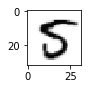

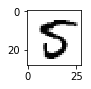

In [15]:
# img_test = cv2.resize(X_train[1],(32,32),interpolation = cv2.INTER_LINEAR)
img_show(X_train_32[11980])

img_show(X_train[11980])
print(X_train_32.shape)
print(X_test_32.shape)

In [16]:
def normal_minist(img):
    return ((img / 255.0) -0.5)*2

In [17]:
def expend_HWC(img):
    return np.expand_dims(img,axis=3)


In [18]:
def to_CHW(img):
    return np.transpose(img,(0,3,1,2))
def to_HWC(img):
    return np.transpose(img,(0,2,3,1))

In [19]:
#只能运行一次
X_train_nor = expend_HWC(X_train_32)
X_train_nor = normal_minist(X_train_nor)
X_train_nor = to_CHW(X_train_nor)
print(X_train_nor.shape)

X_test_nor = expend_HWC(X_test_32)
X_test_nor = normal_minist(X_test_nor)
X_test_nor = to_CHW(X_test_nor)
print(X_test_nor.shape)




(60000, 1, 32, 32)
(10000, 1, 32, 32)


In [20]:
eval_index = [0,6]
negative_index = [1,2,3,4,5,7,8,9]
classes = 10
nn_index = [-1,1]
def compute_index_logical_equal(inputs,indexs):
    logic_result = (inputs==indexs[0])
    for value in indexs:
        logic_result = np.logical_or(inputs == value,logic_result)
    return logic_result

def compute_index_logical_not_equal(inputs,indexs):
    logic_result = (inputs==indexs[0])
    for value in indexs:
        logic_result = np.logical_or(inputs == value,logic_result)
    return np.logical_not(logic_result)

In [21]:
y_test_te = y_test[:10]
print(y_test_te)
print(compute_index_logical_equal(y_test_te,eval_index))
print(compute_index_logical_not_equal(y_test_te,eval_index))
print(y_test_te[compute_index_logical_equal(y_test_te,eval_index)])

[7 2 1 0 4 1 4 9 5 9]
[False False False  True False False False False False False]
[ True  True  True False  True  True  True  True  True  True]
[0]


test_postitive_lable :  (1938,) [0 0 6 0 6 6 0 0 6 6 0 6 0 0 6 6 6 6 6 0 6 0 6 6 0 6 6 0 6 0 6 6 0 0 0 0 6
 6 0 6 0 6 0 0 6 0 0 0 0 0]
test_nagivate_lable :  (8062,) [7 2 1 4 1 4 9 5 9 9 1 5 9 7 3 4 9 5 4 7 4 1 3 1 3 4 7 2 7 1 2 1 1 7 4 2 3
 5 1 2 4 4 3 5 5 4 1 9 5 7]


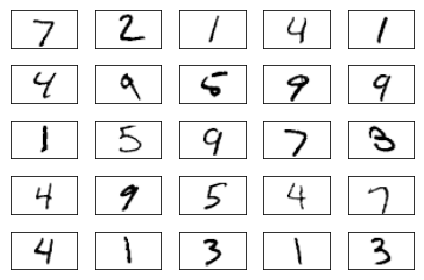

In [22]:
#init test data set
y_test_equal_evla_index = compute_index_logical_equal(y_test,eval_index)
y_test_no_equal_evla_index = compute_index_logical_not_equal(y_test,eval_index)

test_nagivate_lable = y_test[y_test_no_equal_evla_index]
test_nagivate = X_test_nor[y_test_no_equal_evla_index]

test_postitive = X_test_nor[y_test_equal_evla_index]
test_postitive_lable = y_test[y_test_equal_evla_index]
# print(test_postitive[:50])
print("test_postitive_lable : ",test_postitive_lable.shape,test_postitive_lable[:50])
print("test_nagivate_lable : ",test_nagivate_lable.shape,test_nagivate_lable[:50])
imgs_show(np.squeeze(test_nagivate[:25]),5,5)



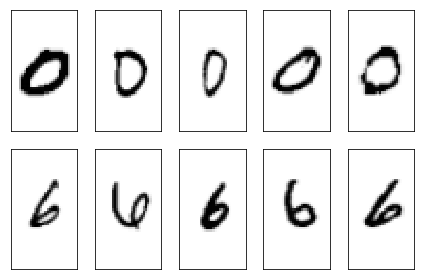

[0 0 0 0 0 6 6 6 6 6]


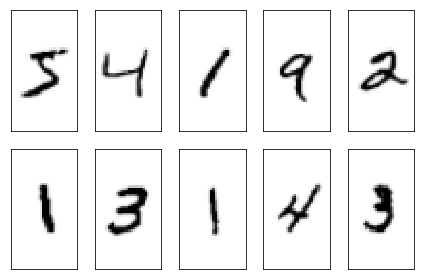

[5 4 1 9 2 1 3 1 4 3]
(48159, 1, 32, 32)


In [23]:
#init train data set
train_positive = []
label_positive =[]
np.random.seed(7)
for value in eval_index :
    
    shuffle_index_positive = np.random.permutation(len(X_train_nor[y_train == value]))
    train_positive.append(X_train_nor[y_train == value][shuffle_index_positive][:5])
    label_positive.append(y_train[y_train == value][shuffle_index_positive][:5])
train_positive = np.concatenate(train_positive)
label_positive = np.concatenate(label_positive)

imgs_show(np.squeeze(train_positive),2,5)
print(label_positive)


train_nagivate = X_train_nor[compute_index_logical_not_equal(y_train ,eval_index)]
label_nagivate = y_train[compute_index_logical_not_equal(y_train , eval_index)]
imgs_show(np.squeeze(train_nagivate[:10]),2,5)
print(label_nagivate[:10])
print(train_nagivate.shape)




In [24]:
def compute_index_logical_equal(inputs,indexs):
    logic_result = (inputs==indexs[0])
    for value in indexs:
        logic_result = np.logical_or(inputs == value,logic_result)
    return logic_result


In [25]:
# class AutoCodeNet(nn.Module):
#     def __init__(self):
#         super(AutoCodeNet,self).__init__()
#         self.conv1 = nn.Conv2d(1,8,kernel_size=3,stride=2,padding=1)
# #         self.pool1 = nn.MaxPool2d(2,2)
#         self.conv2 = nn.Conv2d(8,16,kernel_size=3,stride=2,padding=1)
# #         self.pool2 = nn.MaxPool2d(2,2)
#         self.conv3 = nn.Conv2d(16,24,kernel_size=3,stride=2,padding=1)
# #         self.pool3 = nn.MaxPool2d(2,2,padding=1)

#         self.fc1 = nn.Linear(24*4*4,100)
#         self.fc2 = nn.Linear(100,10)
      
            
        
#         self.up1 = nn.Upsample(scale_factor = 2,mode='nearest')
# #         F.interpolate()
#         self.conv_d1 = nn.Conv2d(24,16,kernel_size=3,stride=1,padding=1)
#         self.up2 = nn.Upsample(scale_factor = 2)
#         self.conv_d2 = nn.Conv2d(16,8,kernel_size=3,stride=1)
#         self.up3 = nn.Upsample(scale_factor = 2)
#         self.conv_d3 = nn.Conv2d(8,8,kernel_size=3,stride=1,padding=1)
        
#         self.conv_d4 = nn.Conv2d(8,1,kernel_size=3,stride=1,padding=1)
        
#         self.features={}
        
#     def decodeForward(self,x):
#         #decode
#         x = F.leaky_relu(self.conv1(x))
#         self.features['relu1'] = x
        
#         x = F.leaky_relu(self.conv2(x))
#         self.features['relu2'] = x
        
#         x = F.leaky_relu(self.conv3(x))
#         self.features['relu3'] = x
        
#         return x
    
#     def encodeforward(self,x):
        
#         x_g = self.up1(x)
#         self.features['up1'] = x_g
#         x_g = F.leaky_relu(self.conv_d1(x_g))
#         self.features['relu_d1'] = x_g
        
#         x_g = self.up2(x_g)
#         self.features['up2'] = x_g
#         x_g = F.leaky_relu(self.conv_d2(x_g))
#         self.features['relu_d2'] = x_g
        
#         x_g = self.up3(x_g)
#         self.features['up3'] = x_g
#         x_g = F.leaky_relu(self.conv_d3(x_g))
#         self.features['relu_d3'] =x_g
        
#         x_g = self.conv_d4(x_g)
#         self.features['conv_d4'] = x_g
        
#         x_g = F.tanh(x_g)
#         self.features['tanh'] = x_g
#         return  x_g
    
#     def class_forward(self,x):
#         x_c = x.view(-1,self.num_flat_features(x))
#         x_c = F.leaky_relu(self.fc1(x_c))
#         x_c = F.dropout(x_c, training=self.training)
#         x_c = self.fc2(x_c)
#         x_c = F.log_softmax(x_c,dim=1)
#         return x_c
    
#     def num_flat_features(self,x):
#         size = x.size()[1:]
#         num_features =1

#         for s in size:
#             num_features *= s
#         return num_features
        
        
#     def forward(self,x):
#         assert len(x) % 3 == 0
        
#         #decode
#         x = self.decodeForward(x)
# #         print('x.size(): ',x.size())

        
        
        
            
            
        
#         #class
#         x_c = self.class_forward(x)
        
#         #encode
#         x_g = self.encodeforward(x)
        
        
#         return x_g ,x_c
        
        
        
        
        
        
        

In [26]:

# def test_glow():
#     print("[Test]: Glow")
    
#     glow = models.Glow(JsonConfig("hparams/celeba_minist.json"),test_class_index=eval_index,is_mean=True,K=4,y_classes=10,is_split_2d=True)
#     # img = cv2.imread("pictures/tsuki.jpeg")
#     # img = cv2.resize(img, (32, 32))
#     # img = (img / 255.0).astype(np.float32)
#     # img = img[:, :, ::-1].transpose(2, 0, 1)
#     # x = torch.Tensor([img]*8)
    
#     x = torch.Tensor(train_positive)
#     print('x.size = ', x.size())

#     batch_size = 10
#     nb_digits = 10
#     y = torch.Tensor(label_positive).long()
#     print('y = ',y)
#     print('y.view(-1,1) = ', y.view(-1,1))
#     y_onehot = torch.FloatTensor(batch_size, nb_digits)
#     y_onehot.zero_()
#     y_onehot.scatter_(1, y.view(-1,1), 1)
#     print('y_onehot:', y_onehot)


#     z, det, y_logits = glow(x=x, y_onehot=y_onehot)
#     print(z.size())
#     print(det)

#     print(models.Glow.loss_generative(det))
#     print('y_logits =  ',y_logits)
#     print(models.Glow.loss_class(y_logits,y))


In [27]:
def getnext(train_x,train_y,batch_size):
    batchs = len(train_y) // batch_size
    print(len(train_y),batchs)

    for i in range(batchs):
        x = train_x[batch_size * i : batch_size * (i+1)]
        y = train_y[batch_size * i : batch_size * (i+1)]
        yield x,y
        

In [28]:
def get_nagivate_next(train_positive,train_nagivate):
    batch_size = len(train_positive) 
    batchs = len(train_nagivate) // batch_size
    print(len(train_nagivate),batchs)
    
    for i in range(batchs):
        x = np.concatenate((train_positive,train_nagivate[batch_size * i : batch_size * (i+1)]))
        y = np.concatenate((np.zeros(batch_size),np.ones(batch_size)))
        shuf_index = np.random.permutation(len(y))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x ,y 
        

In [29]:
def get_nagivate_batch_next(train_positive,train_nagivate,batch_size):
#     batch_size = len(train_positive) 
    batchs = len(train_nagivate) // batch_size
    print(len(train_nagivate),batchs)
    
    for i in range(batchs):
        x = np.concatenate((train_positive,train_nagivate[batch_size * i : batch_size * (i+1)]))
        y = np.concatenate((np.zeros(len(train_positive)),np.ones(len(train_nagivate))))
        shuf_index = np.random.permutation(len(x))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x ,y 

In [30]:
def get_next_posi_nag(train_positive,train_nagivate,label_positive, label_nagivate ,batch_size):
#     batch_size = len(train_positive) 
    batchs = len(train_nagivate) // batch_size
    print(len(train_nagivate),batchs)
    
    for i in range(batchs):
        x = np.concatenate((train_positive,train_nagivate[batch_size * i : batch_size * (i+1)]))
        y = np.concatenate((label_positive,label_nagivate[batch_size * i : batch_size * (i+1)]))
        shuf_index = np.random.permutation(len(x))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x ,y 

In [31]:
def get_next_pn_label(train_positive,train_nagivate,label_positive, label_nagivate):

    class_index_num =[]
    for i in range(1,10):
        class_index_num.append(len(train_nagivate[label_nagivate == i]))
    class_index_num = np.array(class_index_num)
    print('class_index_num = ',class_index_num)
    min_index_num = np.min(class_index_num)
    print('min_index_num = ',min_index_num)
    max_index_num = np.max(class_index_num)
    print('max_index_num = ',max_index_num)
    max_index_class = np.argmax(class_index_num) + 1
    print('max_index_class = ',max_index_class)
    batch_size = 2
    batchs = min_index_num // batch_size
    print('batchs = ',batchs)
    
    
    
    
    
    for i in range(batchs):
        x = train_positive
        y = label_positive
        for class_index in range(1,10):
            
            # batch_index < class len
            if batch_size * (i+1) <= class_index_num[class_index - 1] :
                
                x = np.concatenate( (x,train_nagivate[label_nagivate == class_index][batch_size * i : batch_size * (i+1)]))
                y = np.concatenate((y,label_nagivate[label_nagivate == class_index][batch_size * i : batch_size * (i+1)]))
        
        if len(x) < (3 * len(train_positive)) :
            x = np.concatenate((x,train_nagivate[label_nagivate == max_index_class][batch_size * (i+1) : batch_size * (i+2)]))
            y = np.concatenate((y,label_nagivate[label_nagivate == max_index_class][batch_size * (i+1) : batch_size * (i+2)]))

        shuf_index = np.random.permutation(len(x))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x,y 


In [32]:
def get_next_pn_label2(train_positive,train_nagivate,label_positive, label_nagivate):

    class_index_num =[]
    for value in negative_index:
        class_index_num.append(len(train_nagivate[label_nagivate == value]))
    
    class_index_num = np.array(class_index_num)
    # class_index_num = np.sort(class_index_num)
    print('class_index_num = ',class_index_num)
    
    sort_index_num = np.argsort(class_index_num)
    print('sort_index_num = ',sort_index_num)
    
    min_index_num = class_index_num[sort_index_num[0]]
    max_index_num = class_index_num[sort_index_num[-1]]
    print('min_index_num = ',min_index_num)
    print('max_index_num = ',max_index_num)
    
    max_index_class = negative_index[sort_index_num[-1]]
    max_second_index_class = negative_index[sort_index_num[-2]]
    print('max_index_class = ',max_index_class)
    print('max_second_index_class = ',max_second_index_class)
    
    batch_size = 2
    batchs = min_index_num // batch_size
    print('batchs = ',batchs)
    
    
    
    for i in range(batchs):
        x = []
        y = []
        x.append(train_positive)  
        y.append(label_positive)
        
        for sor_index in sort_index_num :
                class_index = negative_index[sor_index]
#                 print(class_index)
                x.append(train_nagivate[label_nagivate == class_index][batch_size * i : batch_size * (i+1)])
                y.append(label_nagivate[label_nagivate == class_index][batch_size * i : batch_size * (i+1)])
        
        
        x.append(train_nagivate[label_nagivate == max_index_class][-(batch_size * (i+2)):-(batch_size * (i+1)) ])
        y.append(label_nagivate[label_nagivate == max_index_class][-(batch_size * (i+2)):-(batch_size * (i+1)) ])
#         print(label_nagivate[(-batch_size * (i+2)):-2])
        x.append(train_nagivate[label_nagivate == max_second_index_class][-(batch_size * (i+2)):-(batch_size * (i+1)) ])
        y.append(label_nagivate[label_nagivate == max_second_index_class][-(batch_size * (i+2)):-(batch_size * (i+1)) ])
        
#         for i in range(len(x)):
#             print(x[i].shape)
        x = np.concatenate(x)
        y = np.concatenate(y)
        shuf_index = np.random.permutation(len(x))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x,y 

In [33]:
#     train_1 = train_nagivate[y_train == 1]
#     print("train_1.shape = ",train_1.shape)

#     train_2 = train_nagivate[y_train == 2]
#     print("train_2.shape = ",train_2.shape)

#     train_3 = train_nagivate[y_train == 3]
#     print("train_3.shape = ",train_3.shape)

#     train_4 = train_nagivate[y_train == 4]
#     print("train_0.shape = ",train_4.shape)


#     train_5 = train_nagivate[y_train == 5]
#     print("train_0.shape = ",train_5.shape)


#     train_6 = train_nagivate[y_train == 6]
#     print("train_6.shape = ",train_6.shape)

#     train_7 = train_nagivate[y_train == 7]
#     print("train_7.shape = ",train_7.shape)


#     train_8 = train_nagivate[y_train == 8]
#     print("train_8.shape = ",train_8.shape)


#     train_9 = train_nagivate[y_train == 9]
#     print("train_9.shape = ",train_9.shape)
                               
# train_0.shape =  (5923, 1, 28, 28)
# train_1.shape =  (6742, 1, 28, 28)
# train_2.shape =  (5958, 1, 28, 28)
# train_3.shape =  (6131, 1, 28, 28)
# train_4.shape =  (5842, 1, 28, 28)
# train_5.shape =  (5421, 1, 28, 28)
# train_6.shape =  (5918, 1, 28, 28)
# train_7.shape =  (6265, 1, 28, 28)
# train_8.shape =  (5851, 1, 28, 28)
# train_9.shape =  (5949, 1, 28, 28)

In [34]:
# datas = get_next_pn_label2(train_positive,train_nagivate[1100:1200],label_positive,label_nagivate[1100:1200])
# for x,y in datas:
#     print(x.shape)
    
#     print(y)
#     imgs_show(np.squeeze( x),6,5)


In [39]:
batch_size = 30
nb_digits = 10
net_auto =  models.Glow(JsonConfig("hparams/celeba_minist.json"),test_class_index=eval_index,is_mean=True,K=8,y_classes=10)



In [43]:
net_auto.load_state_dict(torch.load('model_few_shot_class_only_minist_55.pt'),strict=True)

In [44]:

# net_auto = torch.load('model_autoEncode5.pkl')
use_cuda = torch.cuda.is_available()
torch.manual_seed(666)
device = torch.device("cuda" if use_cuda else "cpu")
net_auto.to(device)
net_auto.float()


criterion = nn.MSELoss()
optimizer = optim.SGD(net_auto.parameters(),lr=0.001,momentum=0.9,weight_decay=1e-5)


In [46]:
#X_train_nor


for epoch in range(10000):
    #train:
    net_auto.train()
    shuf_nagivate = np.random.permutation(len(train_nagivate))
    train_nagivate = train_nagivate[shuf_nagivate]
    label_nagivate = label_nagivate[shuf_nagivate]
#     datas = get_next_posi_nag(train_positive,train_nagivate,label_positive,label_nagivate, 10)
    datas = get_next_pn_label2(train_positive,train_nagivate,label_positive,label_nagivate)
    
    trainloss_g = 0
    trainloss_c = 0
    
    for x,y in datas:
        inputs ,lables = torch.from_numpy(x).float().to(device),\
            torch.from_numpy(y).long().to(device)
        
        y_onehot = torch.FloatTensor(batch_size, nb_digits).to(device)
        y_onehot.zero_()
        y_onehot.scatter_(1, lables.view(-1,1), 1)
#         print('y_onehot:', y_onehot)


       

        optimizer.zero_grad()
        
        z, det = net_auto(x=inputs, y_onehot=y_onehot)
        y_logits = net_auto.class_flow(z)
        
#         print(z.size())
#         print(det)
        loss_g = models.Glow.loss_generative(det)
        loss_c = models.Glow.loss_class(y_logits,lables)
        
        
#         z, det, y_logits = net_auto(x=inputs, y_onehot=y_onehot)
# #         print(z.size())
# #         print(det)
#         loss_g = models.Glow.loss_generative(det)
#         loss_c = models.Glow.loss_class(y_logits,lables)
        print('epoch   ',epoch,'  loss_g = ',loss_g.item(),'   loss_c =  ',loss_c.item())
#         print('loss_c =  ',loss_c.item())
        loss = loss_g + loss_c*0.2
        loss.backward()
        torch.nn.utils.clip_grad_value_(net_auto.parameters(), 5)
        torch.nn.utils.clip_grad_norm_(net_auto.parameters(), 100)
        
        
        trainloss_g += loss_g.item()
        trainloss_c += loss_c.item()
#         print("net_auto.conv_d1 grad:",net_auto.conv_d1.weight.grad)
        
#         print("after net_auto.conv_1 grad:",net_auto.conv1.weight.grad)
        optimizer.step()
        
    print('%d  gloss: %.3f, class loss:%.3f' % (epoch ,  trainloss_g,trainloss_c))
    
    if epoch % 100 == 0 and epoch >0:
        torch.save(net_auto.state_dict(),'model_few_shot_class_only_minist_'+str(epoch)+'.pt')
    


class_index_num =  [6742 5958 6131 5842 5421 6265 5851 5949]
sort_index_num =  [4 3 6 7 1 2 5 0]
min_index_num =  5421
max_index_num =  6742
max_index_class =  1
max_second_index_class =  7
batchs =  2710
epoch    0   loss_g =  3.25382471085    loss_c =   0.586023628712
epoch    0   loss_g =  3.27703237534    loss_c =   0.690859913826
epoch    0   loss_g =  3.26943969727    loss_c =   0.577060759068
epoch    0   loss_g =  3.33069324493    loss_c =   0.607008039951
epoch    0   loss_g =  3.28384685516    loss_c =   0.738780915737
epoch    0   loss_g =  3.44102835655    loss_c =   0.73921328783
epoch    0   loss_g =  3.26323103905    loss_c =   0.57583373785
epoch    0   loss_g =  3.34536337852    loss_c =   0.710710644722
epoch    0   loss_g =  3.38834142685    loss_c =   0.662879407406
epoch    0   loss_g =  3.38601255417    loss_c =   0.796343743801
epoch    0   loss_g =  3.35733890533    loss_c =   0.501256108284
epoch    0   loss_g =  3.40418338776    loss_c =   0.824887871742
epoch

epoch    0   loss_g =  3.42228960991    loss_c =   0.638715147972
epoch    0   loss_g =  3.51059699059    loss_c =   0.610163152218
epoch    0   loss_g =  3.47520065308    loss_c =   0.485184550285
epoch    0   loss_g =  3.4065527916    loss_c =   0.564104616642
epoch    0   loss_g =  3.44321966171    loss_c =   0.595965325832
epoch    0   loss_g =  3.40545701981    loss_c =   0.709737658501
epoch    0   loss_g =  3.42599391937    loss_c =   0.645493924618
epoch    0   loss_g =  3.41706132889    loss_c =   0.44292652607
epoch    0   loss_g =  3.43710136414    loss_c =   0.501853168011
epoch    0   loss_g =  3.38545393944    loss_c =   0.511848568916
epoch    0   loss_g =  3.39287185669    loss_c =   0.566093444824
epoch    0   loss_g =  3.36433005333    loss_c =   0.451384931803
epoch    0   loss_g =  3.37650513649    loss_c =   0.514655530453
epoch    0   loss_g =  3.32959508896    loss_c =   0.520328223705
epoch    0   loss_g =  3.33336424828    loss_c =   0.686913192272
epoch    0  

epoch    0   loss_g =  3.38726043701    loss_c =   0.644199430943
epoch    0   loss_g =  3.68297171593    loss_c =   2.31516361237
epoch    0   loss_g =  3.63221693039    loss_c =   1.0704331398
epoch    0   loss_g =  4.08893299103    loss_c =   1.64918971062
epoch    0   loss_g =  3.86149072647    loss_c =   1.48639070988
epoch    0   loss_g =  3.56638169289    loss_c =   0.693526864052
epoch    0   loss_g =  3.83314943314    loss_c =   1.27049994469
epoch    0   loss_g =  4.08289813995    loss_c =   11.1799983978
epoch    0   loss_g =  4.96270132065    loss_c =   5.49723243713
epoch    0   loss_g =  4.53725576401    loss_c =   5.79046916962
epoch    0   loss_g =  4.79649782181    loss_c =   3.3490281105
epoch    0   loss_g =  6.07655286789    loss_c =   3.71974635124
epoch    0   loss_g =  5.65822076797    loss_c =   4.93965148926
epoch    0   loss_g =  5.75735855103    loss_c =   5.52279424667
epoch    0   loss_g =  5.82396364212    loss_c =   16.3898925781
epoch    0   loss_g =  5.

epoch    0   loss_g =  3.50419521332    loss_c =   0.707718789577
epoch    0   loss_g =  3.48918914795    loss_c =   0.545204401016
epoch    0   loss_g =  3.48004150391    loss_c =   0.551955103874
epoch    0   loss_g =  3.47320985794    loss_c =   0.566473901272
epoch    0   loss_g =  3.45448374748    loss_c =   0.741110980511
epoch    0   loss_g =  3.56768512726    loss_c =   0.590591371059
epoch    0   loss_g =  3.53752970695    loss_c =   0.806722581387
epoch    0   loss_g =  3.42724108696    loss_c =   0.647534370422
epoch    0   loss_g =  3.42799425125    loss_c =   0.731162488461
epoch    0   loss_g =  3.44483590126    loss_c =   0.616754591465
epoch    0   loss_g =  3.4635424614    loss_c =   0.581698358059
epoch    0   loss_g =  3.53372693062    loss_c =   0.534976601601
epoch    0   loss_g =  3.41065740585    loss_c =   0.641496896744
epoch    0   loss_g =  3.4418618679    loss_c =   0.629956364632
epoch    0   loss_g =  3.4766869545    loss_c =   0.686285912991
epoch    0   

epoch    0   loss_g =  3.33708548546    loss_c =   0.72390460968
epoch    0   loss_g =  3.31472802162    loss_c =   0.524756073952
epoch    0   loss_g =  3.3141977787    loss_c =   0.528944253922
epoch    0   loss_g =  3.35461854935    loss_c =   0.55587041378
epoch    0   loss_g =  3.34654188156    loss_c =   0.50352036953
epoch    0   loss_g =  3.34228086472    loss_c =   0.485801577568
epoch    0   loss_g =  3.30572104454    loss_c =   0.507291555405
epoch    0   loss_g =  3.34696006775    loss_c =   0.55820864439
epoch    0   loss_g =  3.33790946007    loss_c =   0.635041594505
epoch    0   loss_g =  3.36261343956    loss_c =   0.44734442234
epoch    0   loss_g =  3.27325963974    loss_c =   0.559242606163
epoch    0   loss_g =  3.32054805756    loss_c =   0.55835711956
epoch    0   loss_g =  3.38684344292    loss_c =   0.577445566654
epoch    0   loss_g =  3.30043768883    loss_c =   0.659552454948
epoch    0   loss_g =  3.31517863274    loss_c =   0.659588217735
epoch    0   loss

epoch    0   loss_g =  3.36545968056    loss_c =   0.602501153946
epoch    0   loss_g =  3.31695079803    loss_c =   0.54325991869
epoch    0   loss_g =  3.36345911026    loss_c =   0.513106644154
epoch    0   loss_g =  3.26477622986    loss_c =   0.496083140373
epoch    0   loss_g =  3.35790514946    loss_c =   0.484416395426
epoch    0   loss_g =  3.31770682335    loss_c =   0.583400428295
epoch    0   loss_g =  3.30573248863    loss_c =   0.489453226328
epoch    0   loss_g =  3.26717567444    loss_c =   0.432792246342
epoch    0   loss_g =  3.30266046524    loss_c =   0.451682269573
epoch    0   loss_g =  3.26910853386    loss_c =   0.419183731079
epoch    0   loss_g =  3.26235389709    loss_c =   0.42782458663
epoch    0   loss_g =  3.31683564186    loss_c =   0.468258589506
epoch    0   loss_g =  3.35514688492    loss_c =   0.378085494041
epoch    0   loss_g =  3.28441762924    loss_c =   0.486614197493
epoch    0   loss_g =  3.32752728462    loss_c =   0.396505922079
epoch    0  

epoch    0   loss_g =  3.30809926987    loss_c =   0.551230251789
epoch    0   loss_g =  3.25950360298    loss_c =   0.398933917284
epoch    0   loss_g =  3.29083704948    loss_c =   0.73985427618
epoch    0   loss_g =  3.30070352554    loss_c =   0.440688312054
epoch    0   loss_g =  3.27030897141    loss_c =   0.36006128788
epoch    0   loss_g =  3.28739905357    loss_c =   0.431830525398
epoch    0   loss_g =  3.40605020523    loss_c =   0.422952711582
epoch    0   loss_g =  3.2542514801    loss_c =   0.498841285706
epoch    0   loss_g =  3.31962180138    loss_c =   0.482604682446
epoch    0   loss_g =  3.25796556473    loss_c =   0.591662466526
epoch    0   loss_g =  3.27791309357    loss_c =   0.46930283308
epoch    0   loss_g =  3.28885936737    loss_c =   0.655546486378
epoch    0   loss_g =  3.3297097683    loss_c =   0.507013678551
epoch    0   loss_g =  3.2880423069    loss_c =   0.359206080437
epoch    0   loss_g =  3.31117248535    loss_c =   0.423115879297
epoch    0   los

epoch    0   loss_g =  3.23207902908    loss_c =   0.407235503197
epoch    0   loss_g =  3.27544212341    loss_c =   0.363311707973
epoch    0   loss_g =  3.28651237488    loss_c =   0.333560913801
epoch    0   loss_g =  3.26607584953    loss_c =   0.469403207302
epoch    0   loss_g =  3.23012065887    loss_c =   0.635587453842
epoch    0   loss_g =  3.30253720284    loss_c =   0.427503317595
epoch    0   loss_g =  3.28794527054    loss_c =   0.553833067417
epoch    0   loss_g =  3.28263926506    loss_c =   0.513267219067
epoch    0   loss_g =  3.28232598305    loss_c =   0.37142059207
epoch    0   loss_g =  3.34729599953    loss_c =   0.306698858738
epoch    0   loss_g =  3.2270553112    loss_c =   0.480200201273
epoch    0   loss_g =  3.28015756607    loss_c =   0.47051975131
epoch    0   loss_g =  3.31692647934    loss_c =   0.255895555019
epoch    0   loss_g =  3.31453704834    loss_c =   0.422585576773
epoch    0   loss_g =  3.29654526711    loss_c =   0.418285727501
epoch    0   

epoch    0   loss_g =  3.31901884079    loss_c =   0.585341989994
epoch    0   loss_g =  3.2371673584    loss_c =   0.438091725111
epoch    0   loss_g =  3.30252695084    loss_c =   0.569989383221
epoch    0   loss_g =  3.2851088047    loss_c =   0.473815262318
epoch    0   loss_g =  3.2967300415    loss_c =   0.453458398581
epoch    0   loss_g =  3.28417825699    loss_c =   0.584012031555
epoch    0   loss_g =  3.23052287102    loss_c =   0.403056144714
epoch    0   loss_g =  3.29359102249    loss_c =   0.37522855401
epoch    0   loss_g =  3.29489088058    loss_c =   0.53266698122
epoch    0   loss_g =  3.26042675972    loss_c =   0.421223938465
epoch    0   loss_g =  3.22549510002    loss_c =   0.316644400358
epoch    0   loss_g =  3.25789070129    loss_c =   0.322498142719
epoch    0   loss_g =  3.29798674583    loss_c =   0.410485178232
epoch    0   loss_g =  3.25661945343    loss_c =   0.63209605217
epoch    0   loss_g =  3.34951019287    loss_c =   0.649808466434
epoch    0   los

epoch    0   loss_g =  3.3590092659    loss_c =   0.55513548851
epoch    0   loss_g =  3.3277990818    loss_c =   0.450627595186
epoch    0   loss_g =  3.38027667999    loss_c =   0.350498020649
epoch    0   loss_g =  3.27979898453    loss_c =   0.427367627621
epoch    0   loss_g =  3.33774518967    loss_c =   0.345707446337
epoch    0   loss_g =  3.27328205109    loss_c =   0.275369942188
epoch    0   loss_g =  3.33798718452    loss_c =   0.362637996674
epoch    0   loss_g =  3.25500750542    loss_c =   0.667846560478
epoch    0   loss_g =  3.26807045937    loss_c =   0.728272140026
epoch    0   loss_g =  3.2652015686    loss_c =   0.365605741739
epoch    0   loss_g =  3.30649471283    loss_c =   0.374774843454
epoch    0   loss_g =  3.28818655014    loss_c =   0.289477288723
epoch    0   loss_g =  3.30860042572    loss_c =   0.233764126897
epoch    0   loss_g =  3.25282812119    loss_c =   0.417443215847
epoch    0   loss_g =  3.33952832222    loss_c =   0.310598731041
epoch    0   l

epoch    0   loss_g =  3.41781044006    loss_c =   0.260103613138
epoch    0   loss_g =  3.41040921211    loss_c =   0.341194748878
epoch    0   loss_g =  3.35531306267    loss_c =   0.329992324114
epoch    0   loss_g =  3.44076299667    loss_c =   0.407237410545
epoch    0   loss_g =  3.40510010719    loss_c =   0.347617745399
epoch    0   loss_g =  3.44165849686    loss_c =   0.524323642254
epoch    0   loss_g =  3.37376880646    loss_c =   0.574833750725
epoch    0   loss_g =  3.38942742348    loss_c =   0.766225934029
epoch    0   loss_g =  3.48557066917    loss_c =   0.377276539803
epoch    0   loss_g =  3.5246925354    loss_c =   0.481697380543
epoch    0   loss_g =  3.3598074913    loss_c =   0.574045062065
epoch    0   loss_g =  3.47833323479    loss_c =   0.494829744101
epoch    0   loss_g =  3.5491771698    loss_c =   0.431869477034
epoch    0   loss_g =  3.48565888405    loss_c =   0.302399128675
epoch    0   loss_g =  3.48793888092    loss_c =   0.442427963018
epoch    0   

epoch    0   loss_g =  3.46105027199    loss_c =   0.229659900069
epoch    0   loss_g =  3.50396537781    loss_c =   0.588860929012
epoch    0   loss_g =  3.42722535133    loss_c =   0.36615049839
epoch    0   loss_g =  3.39855456352    loss_c =   0.364030539989
epoch    0   loss_g =  3.3710038662    loss_c =   0.549225986004
epoch    0   loss_g =  3.46394491196    loss_c =   0.440812915564
epoch    0   loss_g =  3.45794010162    loss_c =   0.51007860899
epoch    0   loss_g =  3.50077342987    loss_c =   0.249053671956
epoch    0   loss_g =  3.5010266304    loss_c =   0.360218018293
epoch    0   loss_g =  3.47069716454    loss_c =   0.345307052135
epoch    0   loss_g =  3.45839524269    loss_c =   0.457378000021
epoch    0   loss_g =  3.44831204414    loss_c =   0.415635496378
epoch    0   loss_g =  3.41880965233    loss_c =   0.334797888994
epoch    0   loss_g =  3.4643406868    loss_c =   0.304785519838
epoch    0   loss_g =  3.39893293381    loss_c =   0.40836301446
epoch    0   los

epoch    0   loss_g =  3.69082593918    loss_c =   0.385507762432
epoch    0   loss_g =  4.31032085419    loss_c =   1.32878232002
epoch    0   loss_g =  5.04224872589    loss_c =   2.61247634888
epoch    0   loss_g =  5.595454216    loss_c =   2.66335558891
epoch    0   loss_g =  5.54697561264    loss_c =   2.20535326004
epoch    0   loss_g =  5.05778694153    loss_c =   2.16742086411
epoch    0   loss_g =  5.70772266388    loss_c =   3.14712071419
epoch    0   loss_g =  5.36336278915    loss_c =   3.17364788055
epoch    0   loss_g =  5.30085229874    loss_c =   2.50193500519
epoch    0   loss_g =  5.23823928833    loss_c =   1.13077676296
epoch    0   loss_g =  5.42470979691    loss_c =   4.33029222488
epoch    0   loss_g =  5.23976182938    loss_c =   1.80376076698
epoch    0   loss_g =  5.22023487091    loss_c =   1.51460671425
epoch    0   loss_g =  4.96960067749    loss_c =   0.978387951851
epoch    0   loss_g =  4.96504306793    loss_c =   1.86402404308
epoch    0   loss_g =  5.

epoch    0   loss_g =  3.29400873184    loss_c =   0.477932989597
epoch    0   loss_g =  3.37235927582    loss_c =   0.413917422295
epoch    0   loss_g =  3.36617159843    loss_c =   0.405057966709
epoch    0   loss_g =  3.37475728989    loss_c =   0.277878433466
epoch    0   loss_g =  3.42557191849    loss_c =   0.295938760042
epoch    0   loss_g =  3.35409665108    loss_c =   0.219955220819
epoch    0   loss_g =  3.29769039154    loss_c =   0.360733240843
epoch    0   loss_g =  3.34810137749    loss_c =   0.295537680387
epoch    0   loss_g =  3.38468599319    loss_c =   0.519830703735
epoch    0   loss_g =  3.29404139519    loss_c =   0.25669580698
epoch    0   loss_g =  3.34310507774    loss_c =   0.265253901482
epoch    0   loss_g =  3.33264493942    loss_c =   0.336717039347
epoch    0   loss_g =  3.3635532856    loss_c =   0.451014429331
epoch    0   loss_g =  3.34895277023    loss_c =   0.356385618448
epoch    0   loss_g =  3.37720441818    loss_c =   0.281889826059
epoch    0  

epoch    0   loss_g =  3.35396909714    loss_c =   0.243111163378
epoch    0   loss_g =  3.29753851891    loss_c =   0.23129491508
epoch    0   loss_g =  3.35313391685    loss_c =   0.378619968891
epoch    0   loss_g =  3.29636526108    loss_c =   0.322590142488
epoch    0   loss_g =  3.32993841171    loss_c =   0.240140274167
epoch    0   loss_g =  3.38011598587    loss_c =   0.263595610857
epoch    0   loss_g =  3.34392642975    loss_c =   0.270541191101
epoch    0   loss_g =  3.29954862595    loss_c =   0.234143421054
epoch    0   loss_g =  3.38949465752    loss_c =   0.356844514608
epoch    0   loss_g =  3.28761744499    loss_c =   0.411522328854
epoch    0   loss_g =  3.32868909836    loss_c =   0.342789500952
epoch    0   loss_g =  3.3296391964    loss_c =   0.33367857337
epoch    0   loss_g =  3.2952170372    loss_c =   0.28806707263
epoch    0   loss_g =  3.32373547554    loss_c =   0.664862036705
epoch    0   loss_g =  3.31259965897    loss_c =   0.249853104353
epoch    0   lo

epoch    0   loss_g =  3.31558489799    loss_c =   0.222992166877
epoch    0   loss_g =  3.30880999565    loss_c =   0.450742810965
epoch    0   loss_g =  3.35799264908    loss_c =   0.245386898518
epoch    0   loss_g =  3.3077275753    loss_c =   0.46492561698
epoch    0   loss_g =  3.33187389374    loss_c =   0.216000840068
epoch    0   loss_g =  3.32643914223    loss_c =   0.405421853065
epoch    0   loss_g =  3.29671812057    loss_c =   0.297812968493
epoch    0   loss_g =  3.34799289703    loss_c =   0.380683839321
epoch    0   loss_g =  3.348487854    loss_c =   0.357989192009
epoch    0   loss_g =  3.34264087677    loss_c =   0.203749626875
epoch    0   loss_g =  3.31702446938    loss_c =   0.155682787299
epoch    0   loss_g =  3.39950680733    loss_c =   0.508837640285
epoch    0   loss_g =  3.32460618019    loss_c =   0.270082086325
epoch    0   loss_g =  3.26986932755    loss_c =   0.32108604908
epoch    0   loss_g =  3.31637191772    loss_c =   0.333739757538
epoch    0   lo

epoch    0   loss_g =  3.37278628349    loss_c =   0.114885441959
epoch    0   loss_g =  3.32338809967    loss_c =   0.200020104647
epoch    0   loss_g =  3.35909104347    loss_c =   0.525102436543
epoch    0   loss_g =  3.45910024643    loss_c =   0.247839257121
epoch    0   loss_g =  3.41147589684    loss_c =   0.409088492393
epoch    0   loss_g =  3.59603309631    loss_c =   0.513133704662
epoch    0   loss_g =  3.35246658325    loss_c =   0.349496513605
epoch    0   loss_g =  3.54411363602    loss_c =   0.304337471724
epoch    0   loss_g =  3.34647989273    loss_c =   0.120050646365
epoch    0   loss_g =  3.49874019623    loss_c =   0.341386049986
epoch    0   loss_g =  3.39089202881    loss_c =   0.275907814503
epoch    0   loss_g =  3.48608255386    loss_c =   0.182682350278
epoch    0   loss_g =  3.3702287674    loss_c =   0.234287828207
epoch    0   loss_g =  3.4182100296    loss_c =   0.296538472176
epoch    0   loss_g =  3.41744565964    loss_c =   0.264992713928
epoch    0  

epoch    0   loss_g =  3.33153343201    loss_c =   0.495661526918
epoch    0   loss_g =  3.33936667442    loss_c =   0.357447654009
epoch    0   loss_g =  3.30697011948    loss_c =   0.274748623371
epoch    0   loss_g =  3.30623793602    loss_c =   0.31517213583
epoch    0   loss_g =  3.33392715454    loss_c =   0.497105240822
epoch    0   loss_g =  3.42064094543    loss_c =   0.193504884839
epoch    0   loss_g =  3.36147356033    loss_c =   0.279839962721
epoch    0   loss_g =  3.28703165054    loss_c =   0.335354626179
epoch    0   loss_g =  3.37481307983    loss_c =   0.55105894804
epoch    0   loss_g =  3.27621746063    loss_c =   0.260465413332
epoch    0   loss_g =  3.32551622391    loss_c =   0.183840945363
epoch    0   loss_g =  3.37732219696    loss_c =   0.190415933728
epoch    0   loss_g =  3.3224272728    loss_c =   0.222278267145
epoch    0   loss_g =  3.35842084885    loss_c =   0.344289958477
epoch    0   loss_g =  3.29570913315    loss_c =   0.254886776209
epoch    0   

epoch    0   loss_g =  3.23830366135    loss_c =   0.284743964672
epoch    0   loss_g =  3.26143598557    loss_c =   0.214107677341
epoch    0   loss_g =  3.25335502625    loss_c =   0.308313935995
epoch    0   loss_g =  3.30321884155    loss_c =   0.21814776957
epoch    0   loss_g =  3.31396055222    loss_c =   0.504384636879
epoch    0   loss_g =  3.26595973969    loss_c =   0.301802188158
epoch    0   loss_g =  3.35471796989    loss_c =   0.278192609549
epoch    0   loss_g =  3.26798129082    loss_c =   0.172533094883
epoch    0   loss_g =  3.31199932098    loss_c =   0.417018979788
epoch    0   loss_g =  3.34589982033    loss_c =   0.200282275677
epoch    0   loss_g =  3.29060339928    loss_c =   0.118210680783
epoch    0   loss_g =  3.33893275261    loss_c =   0.28968116641
epoch    0   loss_g =  3.29348421097    loss_c =   0.382707178593
epoch    0   loss_g =  3.28645205498    loss_c =   0.193280801177
epoch    0   loss_g =  3.32644224167    loss_c =   0.155514165759
epoch    0  

epoch    0   loss_g =  3.27874422073    loss_c =   0.304253041744
epoch    0   loss_g =  3.27528715134    loss_c =   0.348097831011
epoch    0   loss_g =  3.37891387939    loss_c =   0.377610713243
epoch    0   loss_g =  3.29045939445    loss_c =   0.547556459904
epoch    0   loss_g =  3.29888606071    loss_c =   0.268775671721
epoch    0   loss_g =  3.31424021721    loss_c =   0.218433991075
epoch    0   loss_g =  3.27150917053    loss_c =   0.148513734341
epoch    0   loss_g =  3.26912760735    loss_c =   0.216239407659
epoch    0   loss_g =  3.26338481903    loss_c =   0.37121501565
epoch    0   loss_g =  3.2891356945    loss_c =   0.33551838994
epoch    0   loss_g =  3.26806402206    loss_c =   0.342263907194
epoch    0   loss_g =  3.25171279907    loss_c =   0.178941428661
epoch    0   loss_g =  3.27707052231    loss_c =   0.289254963398
epoch    0   loss_g =  3.30394005775    loss_c =   0.341390073299
epoch    0   loss_g =  3.30431485176    loss_c =   0.236686035991
epoch    0   

epoch    0   loss_g =  3.36793971062    loss_c =   0.325317263603
epoch    0   loss_g =  3.29612565041    loss_c =   0.172916352749
epoch    0   loss_g =  3.29391360283    loss_c =   0.240787684917
epoch    0   loss_g =  3.26859998703    loss_c =   0.354803740978
epoch    0   loss_g =  3.30831503868    loss_c =   0.248377367854
epoch    0   loss_g =  3.24784851074    loss_c =   0.409466087818
epoch    0   loss_g =  3.30520439148    loss_c =   0.223090484738
epoch    0   loss_g =  3.30326414108    loss_c =   0.21573472023
epoch    0   loss_g =  3.29043579102    loss_c =   0.251871198416
epoch    0   loss_g =  3.27443766594    loss_c =   0.301980763674
epoch    0   loss_g =  3.3233332634    loss_c =   0.178668648005
epoch    0   loss_g =  3.29502868652    loss_c =   0.237244784832
epoch    0   loss_g =  3.28848719597    loss_c =   0.258535087109
epoch    0   loss_g =  3.24750351906    loss_c =   0.201387405396
epoch    0   loss_g =  3.32937002182    loss_c =   0.351478099823
epoch    0  

epoch    0   loss_g =  3.51284623146    loss_c =   0.402096837759
epoch    0   loss_g =  3.44217467308    loss_c =   0.305760085583
epoch    0   loss_g =  3.37860631943    loss_c =   0.268265724182
epoch    0   loss_g =  3.45763349533    loss_c =   0.336122989655
epoch    0   loss_g =  3.35875892639    loss_c =   0.186248973012
epoch    0   loss_g =  3.44538617134    loss_c =   0.267506033182
epoch    0   loss_g =  3.37598156929    loss_c =   0.193135723472
epoch    0   loss_g =  3.31718325615    loss_c =   0.422325909138
epoch    0   loss_g =  3.47659754753    loss_c =   0.0996882393956
epoch    0   loss_g =  3.37416529655    loss_c =   0.305532932281
epoch    0   loss_g =  3.50886130333    loss_c =   0.386188417673
epoch    0   loss_g =  3.52017641068    loss_c =   0.306318610907
epoch    0   loss_g =  3.42090392113    loss_c =   0.580413937569
epoch    0   loss_g =  3.43855881691    loss_c =   0.63013535738
epoch    0   loss_g =  3.43989515305    loss_c =   0.356183826923
epoch    0

epoch    1   loss_g =  3.26608419418    loss_c =   0.279330193996
epoch    1   loss_g =  3.32166790962    loss_c =   0.182104170322
epoch    1   loss_g =  3.29396820068    loss_c =   0.258332669735
epoch    1   loss_g =  3.27544569969    loss_c =   0.135862454772
epoch    1   loss_g =  3.34239768982    loss_c =   0.213969990611
epoch    1   loss_g =  3.3265414238    loss_c =   0.293129533529
epoch    1   loss_g =  3.23867821693    loss_c =   0.211375921965
epoch    1   loss_g =  3.26959395409    loss_c =   0.0850948467851
epoch    1   loss_g =  3.27669239044    loss_c =   0.150266572833
epoch    1   loss_g =  3.27398538589    loss_c =   0.234534919262
epoch    1   loss_g =  3.27336573601    loss_c =   0.447771698236
epoch    1   loss_g =  3.26359796524    loss_c =   0.201762452722
epoch    1   loss_g =  3.26167488098    loss_c =   0.293343484402
epoch    1   loss_g =  3.33787155151    loss_c =   0.215724095702
epoch    1   loss_g =  3.25005865097    loss_c =   0.208871334791
epoch    1

epoch    1   loss_g =  3.42731523514    loss_c =   0.232480123639
epoch    1   loss_g =  3.36840486526    loss_c =   0.215888589621
epoch    1   loss_g =  3.32221770287    loss_c =   0.629479527473
epoch    1   loss_g =  3.29978275299    loss_c =   0.284494787455
epoch    1   loss_g =  3.37745261192    loss_c =   0.286102890968
epoch    1   loss_g =  3.31637573242    loss_c =   0.103898890316
epoch    1   loss_g =  3.39631605148    loss_c =   0.245982795954
epoch    1   loss_g =  3.35843276978    loss_c =   0.451183140278
epoch    1   loss_g =  3.33210802078    loss_c =   0.29291921854
epoch    1   loss_g =  3.342867136    loss_c =   0.246803373098
epoch    1   loss_g =  3.41663050652    loss_c =   0.144106566906
epoch    1   loss_g =  3.27749657631    loss_c =   0.3437050879
epoch    1   loss_g =  3.41704893112    loss_c =   0.316613167524
epoch    1   loss_g =  3.42481088638    loss_c =   0.0879186168313
epoch    1   loss_g =  3.38094902039    loss_c =   0.275713920593
epoch    1   l

epoch    1   loss_g =  3.20154905319    loss_c =   0.0918940082192
epoch    1   loss_g =  3.22790956497    loss_c =   0.148286342621
epoch    1   loss_g =  3.26156830788    loss_c =   0.295788824558
epoch    1   loss_g =  3.24950957298    loss_c =   0.241044089198
epoch    1   loss_g =  3.2837498188    loss_c =   0.283357232809
epoch    1   loss_g =  3.28443622589    loss_c =   0.183879211545
epoch    1   loss_g =  3.26336693764    loss_c =   0.14247097075
epoch    1   loss_g =  3.30389118195    loss_c =   0.248726442456
epoch    1   loss_g =  3.24689340591    loss_c =   0.372500866652
epoch    1   loss_g =  3.2441649437    loss_c =   0.274097263813
epoch    1   loss_g =  3.24964666367    loss_c =   0.149285510182
epoch    1   loss_g =  3.26071596146    loss_c =   0.269876509905
epoch    1   loss_g =  3.29316854477    loss_c =   0.191912591457
epoch    1   loss_g =  3.27922487259    loss_c =   0.141113907099
epoch    1   loss_g =  3.25433540344    loss_c =   0.15061815083
epoch    1   

epoch    1   loss_g =  3.3801138401    loss_c =   0.257574945688
epoch    1   loss_g =  3.40705513954    loss_c =   0.289040625095
epoch    1   loss_g =  3.38677453995    loss_c =   0.321448504925
epoch    1   loss_g =  3.33413028717    loss_c =   0.316514074802
epoch    1   loss_g =  3.39308953285    loss_c =   0.156175121665
epoch    1   loss_g =  3.39932608604    loss_c =   0.276288360357
epoch    1   loss_g =  3.31307387352    loss_c =   0.459081947803
epoch    1   loss_g =  3.37254953384    loss_c =   0.488931536674
epoch    1   loss_g =  3.3485891819    loss_c =   0.233752384782
epoch    1   loss_g =  3.27122974396    loss_c =   0.234380304813
epoch    1   loss_g =  3.42681097984    loss_c =   0.395802229643
epoch    1   loss_g =  3.39502906799    loss_c =   0.197367399931
epoch    1   loss_g =  3.37425494194    loss_c =   0.324586689472
epoch    1   loss_g =  3.32547950745    loss_c =   0.243505001068
epoch    1   loss_g =  3.35841917992    loss_c =   0.228820055723
epoch    1  

epoch    1   loss_g =  3.27887821198    loss_c =   0.213391691446
epoch    1   loss_g =  3.30938220024    loss_c =   0.0232044849545
epoch    1   loss_g =  3.22903132439    loss_c =   0.148196399212
epoch    1   loss_g =  3.27911090851    loss_c =   0.121379971504
epoch    1   loss_g =  3.28215026855    loss_c =   0.343580454588
epoch    1   loss_g =  3.26827406883    loss_c =   0.413963496685
epoch    1   loss_g =  3.25454211235    loss_c =   0.292714625597
epoch    1   loss_g =  3.25802731514    loss_c =   0.0627157390118
epoch    1   loss_g =  3.25515770912    loss_c =   0.55428737402
epoch    1   loss_g =  3.30529046059    loss_c =   0.236718565226
epoch    1   loss_g =  3.27783584595    loss_c =   0.352626532316
epoch    1   loss_g =  3.25580382347    loss_c =   0.134615033865
epoch    1   loss_g =  3.34292578697    loss_c =   0.275757670403
epoch    1   loss_g =  3.27900004387    loss_c =   0.113947436213
epoch    1   loss_g =  3.3135881424    loss_c =   0.307633221149
epoch    1

epoch    1   loss_g =  3.32826519012    loss_c =   0.131305545568
epoch    1   loss_g =  3.32067728043    loss_c =   0.251094609499
epoch    1   loss_g =  3.35426235199    loss_c =   0.403005182743
epoch    1   loss_g =  3.43265390396    loss_c =   0.174526438117
epoch    1   loss_g =  3.31569814682    loss_c =   0.131176292896
epoch    1   loss_g =  3.35447216034    loss_c =   0.357154399157
epoch    1   loss_g =  3.45082449913    loss_c =   0.0450734011829
epoch    1   loss_g =  3.32254099846    loss_c =   0.49746671319
epoch    1   loss_g =  3.4470603466    loss_c =   0.279442667961
epoch    1   loss_g =  3.54684567451    loss_c =   0.203518599272
epoch    1   loss_g =  3.48635840416    loss_c =   0.299777984619
epoch    1   loss_g =  3.45781445503    loss_c =   0.393140375614
epoch    1   loss_g =  3.33495187759    loss_c =   0.161275550723
epoch    1   loss_g =  3.39120674133    loss_c =   0.111372388899
epoch    1   loss_g =  3.36567759514    loss_c =   0.262478739023
epoch    1 

epoch    1   loss_g =  3.42651867867    loss_c =   0.10236595571
epoch    1   loss_g =  3.32513833046    loss_c =   0.10873298347
epoch    1   loss_g =  3.33225059509    loss_c =   0.127225145698
epoch    1   loss_g =  3.35843896866    loss_c =   0.124948784709
epoch    1   loss_g =  3.37369704247    loss_c =   0.0998816341162
epoch    1   loss_g =  3.28723978996    loss_c =   0.23983322084
epoch    1   loss_g =  3.39475250244    loss_c =   0.123171947896
epoch    1   loss_g =  3.34265041351    loss_c =   0.152370110154
epoch    1   loss_g =  3.36223888397    loss_c =   0.137779161334
epoch    1   loss_g =  3.3231818676    loss_c =   0.351211637259
epoch    1   loss_g =  3.35736036301    loss_c =   0.120332941413
epoch    1   loss_g =  3.35650086403    loss_c =   0.243276834488
epoch    1   loss_g =  3.36487627029    loss_c =   0.0923349559307
epoch    1   loss_g =  3.36089110374    loss_c =   0.303817808628
epoch    1   loss_g =  3.41134166718    loss_c =   0.166541919112
epoch    1  

epoch    1   loss_g =  3.46403169632    loss_c =   0.142426237464
epoch    1   loss_g =  3.38665223122    loss_c =   0.32166454196
epoch    1   loss_g =  3.51282906532    loss_c =   0.147847831249
epoch    1   loss_g =  3.35212612152    loss_c =   0.254587352276
epoch    1   loss_g =  3.40768623352    loss_c =   0.354580819607
epoch    1   loss_g =  3.36348032951    loss_c =   0.240634277463
epoch    1   loss_g =  3.39853930473    loss_c =   0.266035884619
epoch    1   loss_g =  3.53795933723    loss_c =   0.248470038176
epoch    1   loss_g =  3.49054145813    loss_c =   0.196598723531
epoch    1   loss_g =  3.36940264702    loss_c =   0.362341195345
epoch    1   loss_g =  3.42752742767    loss_c =   0.232046276331
epoch    1   loss_g =  3.4497013092    loss_c =   0.250763386488
epoch    1   loss_g =  3.2960870266    loss_c =   0.066756926477
epoch    1   loss_g =  3.39850020409    loss_c =   0.147387877107
epoch    1   loss_g =  3.38153266907    loss_c =   0.0397973246872
epoch    1  

epoch    1   loss_g =  3.3249168396    loss_c =   0.190301567316
epoch    1   loss_g =  3.23735570908    loss_c =   0.106014914811
epoch    1   loss_g =  3.3318374157    loss_c =   0.272474110126
epoch    1   loss_g =  3.24002599716    loss_c =   0.119530171156
epoch    1   loss_g =  3.3729634285    loss_c =   0.135039269924
epoch    1   loss_g =  3.26794934273    loss_c =   0.235511824489
epoch    1   loss_g =  3.21951675415    loss_c =   0.119472943246
epoch    1   loss_g =  3.23370146751    loss_c =   0.161293312907
epoch    1   loss_g =  3.22840690613    loss_c =   0.0646284967661
epoch    1   loss_g =  3.25419020653    loss_c =   0.122708819807
epoch    1   loss_g =  3.27928447723    loss_c =   0.125104680657
epoch    1   loss_g =  3.30883908272    loss_c =   0.107689283788
epoch    1   loss_g =  3.24954557419    loss_c =   0.237584680319
epoch    1   loss_g =  3.20119643211    loss_c =   0.164858177304
epoch    1   loss_g =  3.2747297287    loss_c =   0.203919678926
epoch    1   

epoch    1   loss_g =  3.38015723228    loss_c =   0.290887773037
epoch    1   loss_g =  3.33338713646    loss_c =   0.271263152361
epoch    1   loss_g =  3.38614869118    loss_c =   0.286341786385
epoch    1   loss_g =  3.26167416573    loss_c =   0.194731101394
epoch    1   loss_g =  3.36295294762    loss_c =   0.294613361359
epoch    1   loss_g =  3.32746887207    loss_c =   0.0858704298735
epoch    1   loss_g =  3.44441795349    loss_c =   0.149500921369
epoch    1   loss_g =  3.36269068718    loss_c =   0.219968155026
epoch    1   loss_g =  3.41308712959    loss_c =   0.100104615092
epoch    1   loss_g =  3.35328674316    loss_c =   0.037567473948
epoch    1   loss_g =  3.34022188187    loss_c =   0.271976113319
epoch    1   loss_g =  3.3651227951    loss_c =   0.253352463245
epoch    1   loss_g =  3.37295603752    loss_c =   0.202080398798
epoch    1   loss_g =  3.35042738914    loss_c =   0.0931925699115
epoch    1   loss_g =  3.35395884514    loss_c =   0.0950037688017
epoch   

epoch    1   loss_g =  3.32570052147    loss_c =   0.234841689467
epoch    1   loss_g =  3.36162590981    loss_c =   0.0917690470815
epoch    1   loss_g =  3.32300972939    loss_c =   0.271103024483
epoch    1   loss_g =  3.42561936378    loss_c =   0.369203090668
epoch    1   loss_g =  3.52847385406    loss_c =   0.218304336071
epoch    1   loss_g =  3.43575048447    loss_c =   0.165415361524
epoch    1   loss_g =  3.44140696526    loss_c =   0.238560751081
epoch    1   loss_g =  3.39109754562    loss_c =   0.253867298365
epoch    1   loss_g =  3.38563418388    loss_c =   0.121759571135
epoch    1   loss_g =  3.4536948204    loss_c =   0.249191343784
epoch    1   loss_g =  3.3921020031    loss_c =   0.0637944787741
epoch    1   loss_g =  3.38853430748    loss_c =   0.271501839161
epoch    1   loss_g =  3.41873002052    loss_c =   0.0698151066899
epoch    1   loss_g =  3.45993638039    loss_c =   0.272735923529
epoch    1   loss_g =  3.50223708153    loss_c =   0.198195070028
epoch    

epoch    1   loss_g =  3.5013256073    loss_c =   0.228393927217
epoch    1   loss_g =  3.41379356384    loss_c =   0.115969590843
epoch    1   loss_g =  3.46479320526    loss_c =   0.185266509652
epoch    1   loss_g =  3.45470666885    loss_c =   0.0806546211243
epoch    1   loss_g =  3.41016960144    loss_c =   0.275154441595
epoch    1   loss_g =  3.37948894501    loss_c =   0.176769986749
epoch    1   loss_g =  3.40185379982    loss_c =   0.513097703457
epoch    1   loss_g =  3.49592494965    loss_c =   0.389998823404
epoch    1   loss_g =  3.41564083099    loss_c =   0.123882040381
epoch    1   loss_g =  3.45102977753    loss_c =   0.150608479977
epoch    1   loss_g =  3.34563016891    loss_c =   0.324068397284
epoch    1   loss_g =  3.40087580681    loss_c =   0.135143280029
epoch    1   loss_g =  3.39599061012    loss_c =   0.238041892648
epoch    1   loss_g =  3.46270704269    loss_c =   0.135864511132
epoch    1   loss_g =  3.37851405144    loss_c =   0.232084169984
epoch    1

epoch    1   loss_g =  3.37826895714    loss_c =   0.112073473632
epoch    1   loss_g =  3.44926691055    loss_c =   0.220356047153
epoch    1   loss_g =  3.34968900681    loss_c =   0.188396260142
epoch    1   loss_g =  3.47021317482    loss_c =   0.0765138417482
epoch    1   loss_g =  3.3315205574    loss_c =   0.339802950621
epoch    1   loss_g =  3.37666893005    loss_c =   0.213542312384
epoch    1   loss_g =  3.39892935753    loss_c =   0.158583030105
epoch    1   loss_g =  3.37213134766    loss_c =   0.0781319960952
epoch    1   loss_g =  3.38892626762    loss_c =   0.245527908206
epoch    1   loss_g =  3.34081506729    loss_c =   0.175698265433
epoch    1   loss_g =  3.38632917404    loss_c =   0.174939230084
epoch    1   loss_g =  3.292719841    loss_c =   0.177851989865
epoch    1   loss_g =  3.36426281929    loss_c =   0.100253678858
epoch    1   loss_g =  3.38336133957    loss_c =   0.157255515456
epoch    1   loss_g =  3.38764023781    loss_c =   0.38060182333
epoch    1  

epoch    1   loss_g =  3.48190522194    loss_c =   0.169266045094
epoch    1   loss_g =  3.4570608139    loss_c =   0.152001842856
epoch    1   loss_g =  3.3924703598    loss_c =   0.237795054913
epoch    1   loss_g =  3.48441171646    loss_c =   0.167598292232
epoch    1   loss_g =  3.46918654442    loss_c =   0.28552672267
epoch    1   loss_g =  3.42490363121    loss_c =   0.0761633738875
epoch    1   loss_g =  3.37874007225    loss_c =   0.111465074122
epoch    1   loss_g =  3.43331170082    loss_c =   0.0633249729872
epoch    1   loss_g =  3.42538952827    loss_c =   0.205525711179
epoch    1   loss_g =  3.39968180656    loss_c =   0.0704477652907
epoch    1   loss_g =  3.46061658859    loss_c =   0.119582168758
epoch    1   loss_g =  3.41914319992    loss_c =   0.183617725968
epoch    1   loss_g =  3.52645349503    loss_c =   0.216281414032
epoch    1   loss_g =  3.42471385002    loss_c =   0.185242280364
epoch    1   loss_g =  3.33189463615    loss_c =   0.173742234707
epoch    1

epoch    1   loss_g =  3.45879793167    loss_c =   0.163881272078
epoch    1   loss_g =  3.41365671158    loss_c =   0.121512062848
epoch    1   loss_g =  3.41116905212    loss_c =   0.124915406108
epoch    1   loss_g =  3.48282384872    loss_c =   0.0418777540326
epoch    1   loss_g =  3.35184836388    loss_c =   0.116350062191
epoch    1   loss_g =  3.38664269447    loss_c =   0.286635309458
epoch    1   loss_g =  3.38820362091    loss_c =   0.105300165713
epoch    1   loss_g =  3.39579558372    loss_c =   0.438275009394
epoch    1   loss_g =  3.31736588478    loss_c =   0.190559491515
epoch    1   loss_g =  3.30495977402    loss_c =   0.159409746528
epoch    1   loss_g =  3.40627145767    loss_c =   0.0500297620893
epoch    1   loss_g =  3.46802973747    loss_c =   0.060053575784
epoch    1   loss_g =  3.36887764931    loss_c =   0.155635043979
epoch    1   loss_g =  3.33821964264    loss_c =   0.174800500274
epoch    1   loss_g =  3.43491172791    loss_c =   0.161161929369
epoch   

epoch    1   loss_g =  3.42257428169    loss_c =   0.152477666736
epoch    1   loss_g =  3.3277926445    loss_c =   0.200002595782
epoch    1   loss_g =  3.37913799286    loss_c =   0.134462743998
epoch    1   loss_g =  3.52849936485    loss_c =   0.177982330322
epoch    1   loss_g =  3.39194822311    loss_c =   0.185560211539
epoch    1   loss_g =  3.42433667183    loss_c =   0.143482774496
epoch    1   loss_g =  3.46591544151    loss_c =   0.0537866279483
epoch    1   loss_g =  3.44618201256    loss_c =   0.104643896222
epoch    1   loss_g =  3.38550639153    loss_c =   0.0617929771543
epoch    1   loss_g =  3.49318957329    loss_c =   0.260266929865
epoch    1   loss_g =  3.40774941444    loss_c =   0.0562673397362
epoch    1   loss_g =  3.49884557724    loss_c =   0.252696216106
epoch    1   loss_g =  3.4511256218    loss_c =   0.245519444346
epoch    1   loss_g =  3.4335334301    loss_c =   0.324693292379
epoch    1   loss_g =  3.37404894829    loss_c =   0.352612763643
epoch    1

epoch    1   loss_g =  3.35631632805    loss_c =   0.0409096889198
epoch    1   loss_g =  3.32438564301    loss_c =   0.117082729936
epoch    1   loss_g =  3.25541353226    loss_c =   0.0919385477901
epoch    1   loss_g =  3.24259972572    loss_c =   0.0928182825446
epoch    1   loss_g =  3.33320093155    loss_c =   0.0793419107795
epoch    1   loss_g =  3.32689118385    loss_c =   0.0404345020652
epoch    1   loss_g =  3.3163599968    loss_c =   0.177829831839
epoch    1   loss_g =  3.33511090279    loss_c =   0.127463668585
epoch    1   loss_g =  3.33299899101    loss_c =   0.460488706827
epoch    1   loss_g =  3.3234462738    loss_c =   0.204823583364
epoch    1   loss_g =  3.30185365677    loss_c =   0.334939330816
epoch    1   loss_g =  3.36314678192    loss_c =   0.126289904118
epoch    1   loss_g =  3.31027293205    loss_c =   0.152384117246
epoch    1   loss_g =  3.29203653336    loss_c =   0.0800627991557
epoch    1   loss_g =  3.42480540276    loss_c =   0.277858287096
epoch 

epoch    1   loss_g =  3.3813598156    loss_c =   0.206227868795
epoch    1   loss_g =  3.34766173363    loss_c =   0.286856859922
epoch    1   loss_g =  3.37391662598    loss_c =   0.207380250096
epoch    1   loss_g =  3.41685175896    loss_c =   0.382303416729
epoch    1   loss_g =  3.42105126381    loss_c =   0.138122290373
epoch    1   loss_g =  3.383061409    loss_c =   0.083800688386
epoch    1   loss_g =  3.33005857468    loss_c =   0.135691359639
epoch    1   loss_g =  3.33519244194    loss_c =   0.0653549954295
epoch    1   loss_g =  3.3213737011    loss_c =   0.040584422648
epoch    1   loss_g =  3.28122329712    loss_c =   0.0869312658906
epoch    1   loss_g =  3.26642131805    loss_c =   0.0652242451906
epoch    1   loss_g =  3.31717395782    loss_c =   0.121030762792
epoch    1   loss_g =  3.28166842461    loss_c =   0.0578716285527
epoch    1   loss_g =  3.23123240471    loss_c =   0.212467581034
epoch    1   loss_g =  3.33937597275    loss_c =   0.142007023096
epoch    1

epoch    1   loss_g =  3.35233974457    loss_c =   0.346745759249
epoch    1   loss_g =  3.40203166008    loss_c =   0.260603755713
epoch    1   loss_g =  3.3658311367    loss_c =   0.171454682946
epoch    1   loss_g =  3.39093494415    loss_c =   0.191200196743
epoch    1   loss_g =  3.28386974335    loss_c =   0.119289323688
epoch    1   loss_g =  3.37411832809    loss_c =   0.29522973299
epoch    1   loss_g =  3.34959125519    loss_c =   0.0535817295313
epoch    1   loss_g =  3.33772993088    loss_c =   0.0237115696073
epoch    1   loss_g =  3.31341814995    loss_c =   0.0727206096053
epoch    1   loss_g =  3.29749679565    loss_c =   0.0980629920959
epoch    1   loss_g =  3.28107500076    loss_c =   0.108043804765
epoch    1   loss_g =  3.36918449402    loss_c =   0.263453066349
epoch    1   loss_g =  3.30690050125    loss_c =   0.253779470921
epoch    1   loss_g =  3.2594935894    loss_c =   0.120152257383
epoch    1   loss_g =  3.3590528965    loss_c =   0.12657776475
epoch    1 

epoch    1   loss_g =  3.35468769073    loss_c =   0.207540214062
epoch    1   loss_g =  3.26046919823    loss_c =   0.10918751359
epoch    1   loss_g =  3.3258535862    loss_c =   0.150113239884
epoch    1   loss_g =  3.40380120277    loss_c =   0.0768030136824
epoch    1   loss_g =  3.38075065613    loss_c =   0.318824857473
epoch    1   loss_g =  3.35041761398    loss_c =   0.130192518234
epoch    1   loss_g =  3.32021856308    loss_c =   0.131320312619
epoch    1   loss_g =  3.38432478905    loss_c =   0.151397779584
epoch    1   loss_g =  3.3340985775    loss_c =   0.175180390477
epoch    1   loss_g =  3.32442259789    loss_c =   0.297091543674
epoch    1   loss_g =  3.39696002007    loss_c =   0.266000926495
epoch    1   loss_g =  3.39551925659    loss_c =   0.424985855818
epoch    1   loss_g =  3.43780016899    loss_c =   0.11732339859
epoch    1   loss_g =  3.27090454102    loss_c =   0.45451977849
epoch    1   loss_g =  3.37466526031    loss_c =   0.175638958812
epoch    1   l

epoch    1   loss_g =  3.30859875679    loss_c =   0.133529722691
epoch    1   loss_g =  3.24601984024    loss_c =   0.0544754490256
epoch    1   loss_g =  3.29893159866    loss_c =   0.175104469061
epoch    1   loss_g =  3.30942583084    loss_c =   0.0712438598275
epoch    1   loss_g =  3.22384691238    loss_c =   0.0795292034745
epoch    1   loss_g =  3.28102374077    loss_c =   0.0603958554566
epoch    1   loss_g =  3.26812028885    loss_c =   0.11436701566
epoch    1   loss_g =  3.24338316917    loss_c =   0.320749849081
epoch    1   loss_g =  3.27855587006    loss_c =   0.168013989925
epoch    1   loss_g =  3.26831936836    loss_c =   0.0728517398238
epoch    1   loss_g =  3.22321462631    loss_c =   0.13325740397
epoch    1   loss_g =  3.34579324722    loss_c =   0.206150904298
epoch    1   loss_g =  3.30827832222    loss_c =   0.0659623816609
epoch    1   loss_g =  3.27112984657    loss_c =   0.201330989599
epoch    1   loss_g =  3.34868502617    loss_c =   0.180164918303
epoch 

epoch    1   loss_g =  3.27453780174    loss_c =   0.317554503679
epoch    1   loss_g =  3.35549163818    loss_c =   0.226048141718
epoch    1   loss_g =  3.37647747993    loss_c =   0.192958146334
epoch    1   loss_g =  3.32571959496    loss_c =   0.15021713078
epoch    1   loss_g =  3.39776992798    loss_c =   0.149613633752
epoch    1   loss_g =  3.36477231979    loss_c =   0.105413384736
epoch    1   loss_g =  3.35743379593    loss_c =   0.126013845205
epoch    1   loss_g =  3.32063317299    loss_c =   0.100832134485
epoch    1   loss_g =  3.29601931572    loss_c =   0.0421416051686
epoch    1   loss_g =  3.34207105637    loss_c =   0.145865187049
epoch    1   loss_g =  3.30949902534    loss_c =   0.0608972348273
epoch    1   loss_g =  3.319470644    loss_c =   0.236086562276
epoch    1   loss_g =  3.24981474876    loss_c =   0.08010109514
epoch    1   loss_g =  3.42632627487    loss_c =   0.312938898802
epoch    1   loss_g =  3.28702664375    loss_c =   0.458107769489
epoch    1  

epoch    2   loss_g =  3.44845223427    loss_c =   0.256833463907
epoch    2   loss_g =  3.4409468174    loss_c =   0.0873119980097
epoch    2   loss_g =  3.43612575531    loss_c =   0.0905252546072
epoch    2   loss_g =  3.48160672188    loss_c =   0.175367295742
epoch    2   loss_g =  3.42055726051    loss_c =   0.147081434727
epoch    2   loss_g =  3.5082449913    loss_c =   0.220003992319
epoch    2   loss_g =  3.40554714203    loss_c =   0.181297525764
epoch    2   loss_g =  3.51302480698    loss_c =   0.284492373466
epoch    2   loss_g =  3.45295500755    loss_c =   0.416934221983
epoch    2   loss_g =  3.49426651001    loss_c =   0.146224915981
epoch    2   loss_g =  3.42140746117    loss_c =   0.215553626418
epoch    2   loss_g =  3.552298069    loss_c =   0.331100434065
epoch    2   loss_g =  3.39623451233    loss_c =   0.205217197537
epoch    2   loss_g =  3.46363449097    loss_c =   0.030883288011
epoch    2   loss_g =  3.45081973076    loss_c =   0.0798821300268
epoch    2 

epoch    2   loss_g =  3.74821639061    loss_c =   0.308094054461
epoch    2   loss_g =  3.85737037659    loss_c =   0.231705516577
epoch    2   loss_g =  3.69753360748    loss_c =   0.232327520847
epoch    2   loss_g =  3.64710640907    loss_c =   0.264655739069
epoch    2   loss_g =  3.6359732151    loss_c =   0.19512873888
epoch    2   loss_g =  3.6925008297    loss_c =   0.0866561308503
epoch    2   loss_g =  3.71835589409    loss_c =   0.105355136096
epoch    2   loss_g =  3.67695426941    loss_c =   0.586542487144
epoch    2   loss_g =  3.62654328346    loss_c =   0.114847384393
epoch    2   loss_g =  3.61795639992    loss_c =   0.255027323961
epoch    2   loss_g =  3.64511752129    loss_c =   0.270374149084
epoch    2   loss_g =  3.54321551323    loss_c =   0.181268498302
epoch    2   loss_g =  3.60424280167    loss_c =   0.0384422950447
epoch    2   loss_g =  3.601136446    loss_c =   0.0616610832512
epoch    2   loss_g =  3.5595600605    loss_c =   0.0869071707129
epoch    2  

epoch    2   loss_g =  3.31709003448    loss_c =   0.401258856058
epoch    2   loss_g =  3.37617635727    loss_c =   0.173585191369
epoch    2   loss_g =  3.30752944946    loss_c =   0.0630690529943
epoch    2   loss_g =  3.31499624252    loss_c =   0.27204194665
epoch    2   loss_g =  3.35748744011    loss_c =   0.120085053146
epoch    2   loss_g =  3.33273100853    loss_c =   0.12192248553
epoch    2   loss_g =  3.3723897934    loss_c =   0.147710606456
epoch    2   loss_g =  3.43523240089    loss_c =   0.25482070446
epoch    2   loss_g =  3.33898949623    loss_c =   0.101195342839
epoch    2   loss_g =  3.3496491909    loss_c =   0.109274767339
epoch    2   loss_g =  3.35890436172    loss_c =   0.127860069275
epoch    2   loss_g =  3.4160323143    loss_c =   0.333534628153
epoch    2   loss_g =  3.3040869236    loss_c =   0.0922643169761
epoch    2   loss_g =  3.43648719788    loss_c =   0.263470053673
epoch    2   loss_g =  3.43636059761    loss_c =   0.0204029958695
epoch    2   l

epoch    2   loss_g =  3.42880630493    loss_c =   0.539633929729
epoch    2   loss_g =  3.30697059631    loss_c =   0.375771105289
epoch    2   loss_g =  3.36704325676    loss_c =   0.165125399828
epoch    2   loss_g =  3.33778071404    loss_c =   0.193862944841
epoch    2   loss_g =  3.40159845352    loss_c =   0.197626546025
epoch    2   loss_g =  3.31262540817    loss_c =   0.0675308778882
epoch    2   loss_g =  3.34772062302    loss_c =   0.251545280218
epoch    2   loss_g =  3.34762430191    loss_c =   0.133707851171
epoch    2   loss_g =  3.36746931076    loss_c =   0.234079509974
epoch    2   loss_g =  3.41575312614    loss_c =   0.216218024492
epoch    2   loss_g =  3.34590435028    loss_c =   0.402896791697
epoch    2   loss_g =  3.34287524223    loss_c =   0.145383894444
epoch    2   loss_g =  3.40980291367    loss_c =   0.169548913836
epoch    2   loss_g =  3.35663056374    loss_c =   0.170768111944
epoch    2   loss_g =  3.34334397316    loss_c =   0.251498430967
epoch    

epoch    2   loss_g =  3.3581097126    loss_c =   0.102554962039
epoch    2   loss_g =  3.46739912033    loss_c =   0.197951957583
epoch    2   loss_g =  3.46020674706    loss_c =   0.138699993491
epoch    2   loss_g =  3.45803809166    loss_c =   0.101178906858
epoch    2   loss_g =  3.4654583931    loss_c =   0.148423761129
epoch    2   loss_g =  3.37227320671    loss_c =   0.272823005915
epoch    2   loss_g =  3.39967870712    loss_c =   0.0685651749372
epoch    2   loss_g =  3.32543897629    loss_c =   0.120316848159
epoch    2   loss_g =  3.41272759438    loss_c =   0.189632892609
epoch    2   loss_g =  3.3440952301    loss_c =   0.0666417479515
epoch    2   loss_g =  3.39899134636    loss_c =   0.167576923966
epoch    2   loss_g =  3.41902065277    loss_c =   0.150154784322
epoch    2   loss_g =  3.34096980095    loss_c =   0.220813438296
epoch    2   loss_g =  3.27715706825    loss_c =   0.259565919638
epoch    2   loss_g =  3.36538815498    loss_c =   0.0352401584387
epoch    2

epoch    2   loss_g =  3.36490678787    loss_c =   0.273476272821
epoch    2   loss_g =  3.39141106606    loss_c =   0.205353334546
epoch    2   loss_g =  3.31454229355    loss_c =   0.521951019764
epoch    2   loss_g =  3.33541870117    loss_c =   0.0816836804152
epoch    2   loss_g =  3.44489789009    loss_c =   0.231518089771
epoch    2   loss_g =  3.42135286331    loss_c =   0.271588712931
epoch    2   loss_g =  3.52323532104    loss_c =   0.144392192364
epoch    2   loss_g =  3.41290450096    loss_c =   0.320221275091
epoch    2   loss_g =  3.41871166229    loss_c =   0.0671744048595
epoch    2   loss_g =  3.45780181885    loss_c =   0.184474527836
epoch    2   loss_g =  3.42927765846    loss_c =   0.122720636427
epoch    2   loss_g =  3.44347167015    loss_c =   0.518544137478
epoch    2   loss_g =  3.46430253983    loss_c =   0.169160783291
epoch    2   loss_g =  3.40922737122    loss_c =   0.282063364983
epoch    2   loss_g =  3.43460988998    loss_c =   0.0964094847441
epoch  

epoch    2   loss_g =  3.33471655846    loss_c =   0.132139846683
epoch    2   loss_g =  3.30300045013    loss_c =   0.00859602261335
epoch    2   loss_g =  3.2958586216    loss_c =   0.0475040525198
epoch    2   loss_g =  3.34827589989    loss_c =   0.0783548802137
epoch    2   loss_g =  3.33989953995    loss_c =   0.102849319577
epoch    2   loss_g =  3.33276772499    loss_c =   0.0185428783298
epoch    2   loss_g =  3.34063744545    loss_c =   0.144786804914
epoch    2   loss_g =  3.31789207458    loss_c =   0.0773179978132
epoch    2   loss_g =  3.27896690369    loss_c =   0.0350631400943
epoch    2   loss_g =  3.34998583794    loss_c =   0.216422215104
epoch    2   loss_g =  3.34398651123    loss_c =   0.076164484024
epoch    2   loss_g =  3.27010059357    loss_c =   0.129096135497
epoch    2   loss_g =  3.30853557587    loss_c =   0.391139060259
epoch    2   loss_g =  3.29462838173    loss_c =   0.250743150711
epoch    2   loss_g =  3.322067976    loss_c =   0.0552883632481
epoch

epoch    2   loss_g =  3.31717133522    loss_c =   0.129796266556
epoch    2   loss_g =  3.2813808918    loss_c =   0.0448664203286
epoch    2   loss_g =  3.31897735596    loss_c =   0.080116763711
epoch    2   loss_g =  3.34856462479    loss_c =   0.394282490015
epoch    2   loss_g =  3.2737057209    loss_c =   0.113072112203
epoch    2   loss_g =  3.33460307121    loss_c =   0.169370412827
epoch    2   loss_g =  3.30660200119    loss_c =   0.0784834101796
epoch    2   loss_g =  3.32238817215    loss_c =   0.0802045688033
epoch    2   loss_g =  3.34705376625    loss_c =   0.289012283087
epoch    2   loss_g =  3.34653115273    loss_c =   0.399839192629
epoch    2   loss_g =  3.27129101753    loss_c =   0.0999106615782
epoch    2   loss_g =  3.3244395256    loss_c =   0.0430059842765
epoch    2   loss_g =  3.31295990944    loss_c =   0.0896270796657
epoch    2   loss_g =  3.31345105171    loss_c =   0.278390467167
epoch    2   loss_g =  3.32121896744    loss_c =   0.0873682126403
epoch 

epoch    2   loss_g =  3.3759791851    loss_c =   0.102815821767
epoch    2   loss_g =  3.38153338432    loss_c =   0.055840857327
epoch    2   loss_g =  3.37709283829    loss_c =   0.0787344798446
epoch    2   loss_g =  3.3349108696    loss_c =   0.167910814285
epoch    2   loss_g =  3.28428792953    loss_c =   0.1648234725
epoch    2   loss_g =  3.38443207741    loss_c =   0.226366892457
epoch    2   loss_g =  3.33760857582    loss_c =   0.106765203178
epoch    2   loss_g =  3.37598872185    loss_c =   0.0760883241892
epoch    2   loss_g =  3.33304047585    loss_c =   0.0637992098927
epoch    2   loss_g =  3.39650201797    loss_c =   0.340063273907
epoch    2   loss_g =  3.36048984528    loss_c =   0.114134378731
epoch    2   loss_g =  3.31608271599    loss_c =   0.0854122787714
epoch    2   loss_g =  3.34307193756    loss_c =   0.0863687321544
epoch    2   loss_g =  3.39129853249    loss_c =   0.757455587387
epoch    2   loss_g =  3.35876822472    loss_c =   0.0871172174811
epoch   

epoch    2   loss_g =  3.28383588791    loss_c =   0.110022515059
epoch    2   loss_g =  3.27901959419    loss_c =   0.0444111600518
epoch    2   loss_g =  3.25243616104    loss_c =   0.216295227408
epoch    2   loss_g =  3.23818325996    loss_c =   0.0899561792612
epoch    2   loss_g =  3.27036166191    loss_c =   0.314023345709
epoch    2   loss_g =  3.29903864861    loss_c =   0.276821255684
epoch    2   loss_g =  3.29637932777    loss_c =   0.202994585037
epoch    2   loss_g =  3.28377509117    loss_c =   0.0811825245619
epoch    2   loss_g =  3.27887940407    loss_c =   0.170203968883
epoch    2   loss_g =  3.2680106163    loss_c =   0.07935808599
epoch    2   loss_g =  3.27814054489    loss_c =   0.0678075328469
epoch    2   loss_g =  3.28579354286    loss_c =   0.0874909162521
epoch    2   loss_g =  3.30929064751    loss_c =   0.0515590049326
epoch    2   loss_g =  3.30476498604    loss_c =   0.347028613091
epoch    2   loss_g =  3.29015016556    loss_c =   0.139032095671
epoch 

epoch    2   loss_g =  3.34931778908    loss_c =   0.0186952278018
epoch    2   loss_g =  3.28321909904    loss_c =   0.266064733267
epoch    2   loss_g =  3.35729408264    loss_c =   0.0702981948853
epoch    2   loss_g =  3.28488254547    loss_c =   0.0741519480944
epoch    2   loss_g =  3.30212759972    loss_c =   0.0930505916476
epoch    2   loss_g =  3.29939365387    loss_c =   0.0611844919622
epoch    2   loss_g =  3.2590239048    loss_c =   0.0446312576532
epoch    2   loss_g =  3.28719186783    loss_c =   0.188814535737
epoch    2   loss_g =  3.2727689743    loss_c =   0.23280659318
epoch    2   loss_g =  3.31514239311    loss_c =   0.0528714992106
epoch    2   loss_g =  3.28495049477    loss_c =   0.148453503847
epoch    2   loss_g =  3.26678538322    loss_c =   0.0542191825807
epoch    2   loss_g =  3.26266479492    loss_c =   0.176177754998
epoch    2   loss_g =  3.27919840813    loss_c =   0.111668840051
epoch    2   loss_g =  3.34055352211    loss_c =   0.0954311192036
epoc

epoch    2   loss_g =  3.37533521652    loss_c =   0.104644343257
epoch    2   loss_g =  3.32915663719    loss_c =   0.415607064962
epoch    2   loss_g =  3.46352386475    loss_c =   0.113506808877
epoch    2   loss_g =  3.38179826736    loss_c =   0.241174444556
epoch    2   loss_g =  3.50610303879    loss_c =   0.0754334926605
epoch    2   loss_g =  3.37201809883    loss_c =   0.233396157622
epoch    2   loss_g =  3.43491196632    loss_c =   0.0327314771712
epoch    2   loss_g =  3.32763004303    loss_c =   0.113092258573
epoch    2   loss_g =  3.38106894493    loss_c =   0.286956876516
epoch    2   loss_g =  3.30193519592    loss_c =   0.281987696886
epoch    2   loss_g =  3.37049603462    loss_c =   0.156256660819
epoch    2   loss_g =  3.34032869339    loss_c =   0.13030295074
epoch    2   loss_g =  3.30332326889    loss_c =   0.0665372237563
epoch    2   loss_g =  3.33500790596    loss_c =   0.0856140702963
epoch    2   loss_g =  3.33777046204    loss_c =   0.240945592523
epoch  

epoch    2   loss_g =  3.33575820923    loss_c =   0.111864022911
epoch    2   loss_g =  3.34750819206    loss_c =   0.134010508657
epoch    2   loss_g =  3.36725640297    loss_c =   0.377258479595
epoch    2   loss_g =  3.28421354294    loss_c =   0.296980708838
epoch    2   loss_g =  3.35218858719    loss_c =   0.190598458052
epoch    2   loss_g =  3.3258869648    loss_c =   0.0684665739536
epoch    2   loss_g =  3.39172625542    loss_c =   0.0630399435759
epoch    2   loss_g =  3.36108660698    loss_c =   0.0927599668503
epoch    2   loss_g =  3.36642098427    loss_c =   0.210780724883
epoch    2   loss_g =  3.36150026321    loss_c =   0.183399155736
epoch    2   loss_g =  3.38351964951    loss_c =   0.0595721416175
epoch    2   loss_g =  3.41177940369    loss_c =   0.177695691586
epoch    2   loss_g =  3.38729953766    loss_c =   0.0788204967976
epoch    2   loss_g =  3.31713867188    loss_c =   0.115603223443
epoch    2   loss_g =  3.35780119896    loss_c =   0.0291093271226
epoch

epoch    2   loss_g =  3.35601663589    loss_c =   0.289081215858
epoch    2   loss_g =  3.34474730492    loss_c =   0.0990781858563
epoch    2   loss_g =  3.38532757759    loss_c =   0.251842260361
epoch    2   loss_g =  3.29855895042    loss_c =   0.144657924771
epoch    2   loss_g =  3.3108959198    loss_c =   0.384763091803
epoch    2   loss_g =  3.34696698189    loss_c =   0.0688388124108
epoch    2   loss_g =  3.27204275131    loss_c =   0.0231066700071
epoch    2   loss_g =  3.32885932922    loss_c =   0.0327319763601
epoch    2   loss_g =  3.38439798355    loss_c =   0.163921609521
epoch    2   loss_g =  3.28961539268    loss_c =   0.164125621319
epoch    2   loss_g =  3.28544354439    loss_c =   0.112244293094
epoch    2   loss_g =  3.33367729187    loss_c =   0.0780054628849
epoch    2   loss_g =  3.31588315964    loss_c =   0.0815828815103
epoch    2   loss_g =  3.30131483078    loss_c =   0.137971505523
epoch    2   loss_g =  3.32407879829    loss_c =   0.253800272942
epoch

epoch    2   loss_g =  3.4161696434    loss_c =   0.0471179075539
epoch    2   loss_g =  3.33362793922    loss_c =   0.241137102246
epoch    2   loss_g =  3.3024263382    loss_c =   0.0564300976694
epoch    2   loss_g =  3.39973855019    loss_c =   0.0672414824367
epoch    2   loss_g =  3.26514959335    loss_c =   0.347420066595
epoch    2   loss_g =  3.3480181694    loss_c =   0.203901231289
epoch    2   loss_g =  3.39939618111    loss_c =   0.0898743718863
epoch    2   loss_g =  3.31998205185    loss_c =   0.0135447345674
epoch    2   loss_g =  3.40195298195    loss_c =   0.0248207878321
epoch    2   loss_g =  3.34198522568    loss_c =   0.0567062310874
epoch    2   loss_g =  3.36580896378    loss_c =   0.127491757274
epoch    2   loss_g =  3.3700594902    loss_c =   0.077720426023
epoch    2   loss_g =  3.34531927109    loss_c =   0.175421401858
epoch    2   loss_g =  3.28467845917    loss_c =   0.105494864285
epoch    2   loss_g =  3.3548707962    loss_c =   0.182460725307
epoch   

epoch    2   loss_g =  3.34886670113    loss_c =   0.169580176473
epoch    2   loss_g =  3.32507801056    loss_c =   0.144114032388
epoch    2   loss_g =  3.28499174118    loss_c =   0.248157188296
epoch    2   loss_g =  3.33737444878    loss_c =   0.0972895547748
epoch    2   loss_g =  3.29257702827    loss_c =   0.174593925476
epoch    2   loss_g =  3.27274870872    loss_c =   0.165285333991
epoch    2   loss_g =  3.29158091545    loss_c =   0.214146077633
epoch    2   loss_g =  3.28624415398    loss_c =   0.293985426426
epoch    2   loss_g =  3.31284284592    loss_c =   0.0540210977197
epoch    2   loss_g =  3.30078649521    loss_c =   0.124801151454
epoch    2   loss_g =  3.30884242058    loss_c =   0.0332526043057
epoch    2   loss_g =  3.32274842262    loss_c =   0.027241492644
epoch    2   loss_g =  3.29438614845    loss_c =   0.0999728813767
epoch    2   loss_g =  3.24683737755    loss_c =   0.224280267954
epoch    2   loss_g =  3.37373304367    loss_c =   0.19378836453
epoch  

epoch    2   loss_g =  3.22967481613    loss_c =   0.0922733917832
epoch    2   loss_g =  3.25891923904    loss_c =   0.168090119958
epoch    2   loss_g =  3.23525667191    loss_c =   0.34064117074
epoch    2   loss_g =  3.27782130241    loss_c =   0.156771942973
epoch    2   loss_g =  3.29288864136    loss_c =   0.0324896425009
epoch    2   loss_g =  3.3064455986    loss_c =   0.102773047984
epoch    2   loss_g =  3.26263070107    loss_c =   0.179769963026
epoch    2   loss_g =  3.25917029381    loss_c =   0.114028997719
epoch    2   loss_g =  3.2771832943    loss_c =   0.0832452103496
epoch    2   loss_g =  3.29743051529    loss_c =   0.0355629138649
epoch    2   loss_g =  3.30625605583    loss_c =   0.153398886323
epoch    2   loss_g =  3.2230219841    loss_c =   0.165788605809
epoch    2   loss_g =  3.31954813004    loss_c =   0.023061864078
epoch    2   loss_g =  3.29656100273    loss_c =   0.0623473711312
epoch    2   loss_g =  3.2931470871    loss_c =   0.0724736824632
epoch    

epoch    2   loss_g =  3.30924510956    loss_c =   0.219688341022
epoch    2   loss_g =  3.36435651779    loss_c =   0.225520685315
epoch    2   loss_g =  3.37798023224    loss_c =   0.202070876956
epoch    2   loss_g =  3.37459850311    loss_c =   0.18850825727
epoch    2   loss_g =  3.35744261742    loss_c =   0.158185586333
epoch    2   loss_g =  3.32945680618    loss_c =   0.100075997412
epoch    2   loss_g =  3.34852862358    loss_c =   0.139901980758
epoch    2   loss_g =  3.37436413765    loss_c =   0.059810474515
epoch    2   loss_g =  3.39417219162    loss_c =   0.318021953106
epoch    2   loss_g =  3.34729194641    loss_c =   0.134292036295
epoch    2   loss_g =  3.47071266174    loss_c =   0.166541531682
epoch    2   loss_g =  3.3696782589    loss_c =   0.516974151134
epoch    2   loss_g =  3.43124961853    loss_c =   0.232625454664
epoch    2   loss_g =  3.38345694542    loss_c =   0.0606330148876
epoch    2   loss_g =  3.42266559601    loss_c =   0.133175358176
epoch    2 

epoch    2   loss_g =  3.43463945389    loss_c =   0.157517969608
epoch    2   loss_g =  3.34432983398    loss_c =   0.169887766242
epoch    2   loss_g =  3.38698601723    loss_c =   0.075427994132
epoch    2   loss_g =  3.39511060715    loss_c =   0.23859539628
epoch    2   loss_g =  3.37141752243    loss_c =   0.0393422357738
epoch    2   loss_g =  3.34649753571    loss_c =   0.0901536047459
epoch    2   loss_g =  3.29468178749    loss_c =   0.254238992929
epoch    2   loss_g =  3.33637881279    loss_c =   0.381320476532
epoch    2   loss_g =  3.26095795631    loss_c =   0.15520593524
epoch    2   loss_g =  3.22455859184    loss_c =   0.194250196218
epoch    2   loss_g =  3.33495926857    loss_c =   0.258459717035
epoch    2   loss_g =  3.31352829933    loss_c =   0.195240646601
epoch    2   loss_g =  3.31759619713    loss_c =   0.00943578127772
epoch    2   loss_g =  3.29664230347    loss_c =   0.320529818535
epoch    2   loss_g =  3.29246807098    loss_c =   0.107348076999
epoch   

epoch    2   loss_g =  3.24069547653    loss_c =   0.229704663157
epoch    2   loss_g =  3.32329297066    loss_c =   0.0502943508327
epoch    2   loss_g =  3.27748823166    loss_c =   0.236656248569
epoch    2   loss_g =  3.24491238594    loss_c =   0.0488974712789
epoch    2   loss_g =  3.27081394196    loss_c =   0.202048972249
epoch    2   loss_g =  3.27480888367    loss_c =   0.105930767953
epoch    2   loss_g =  3.30394816399    loss_c =   0.167314961553
epoch    2   loss_g =  3.30235052109    loss_c =   0.231034368277
epoch    2   loss_g =  3.32993006706    loss_c =   0.352902501822
epoch    2   loss_g =  3.29462766647    loss_c =   0.0371215343475
epoch    2   loss_g =  3.27820587158    loss_c =   0.0874682739377
epoch    2   loss_g =  3.27998542786    loss_c =   0.0532531961799
epoch    2   loss_g =  3.25890398026    loss_c =   0.151971966028
epoch    2   loss_g =  3.20653891563    loss_c =   0.156109556556
epoch    2   loss_g =  3.22525286674    loss_c =   0.0720659717917
epoc

epoch    2   loss_g =  3.22487735748    loss_c =   0.0254422035068
epoch    2   loss_g =  3.23483896255    loss_c =   0.129457980394
epoch    2   loss_g =  3.26461434364    loss_c =   0.0974433273077
epoch    2   loss_g =  3.22549510002    loss_c =   0.0272186603397
epoch    2   loss_g =  3.27820682526    loss_c =   0.0886622369289
epoch    2   loss_g =  3.21091628075    loss_c =   0.199668943882
epoch    2   loss_g =  3.24101924896    loss_c =   0.233910351992
epoch    2   loss_g =  3.32869982719    loss_c =   0.17255191505
epoch    2   loss_g =  3.30306434631    loss_c =   0.0422606542706
epoch    2   loss_g =  3.34132218361    loss_c =   0.0925527587533
epoch    2   loss_g =  3.28056669235    loss_c =   0.156944349408
epoch    2   loss_g =  3.27279448509    loss_c =   0.0691301003098
epoch    2   loss_g =  3.21798825264    loss_c =   0.105424448848
epoch    2   loss_g =  3.25701403618    loss_c =   0.38188201189
epoch    2   loss_g =  3.19956851006    loss_c =   0.156762346625
epoch

epoch    2   loss_g =  3.27247214317    loss_c =   0.0894136875868
epoch    2   loss_g =  3.30691957474    loss_c =   0.195964723825
epoch    2   loss_g =  3.32160592079    loss_c =   0.152042716742
epoch    2   loss_g =  3.2633934021    loss_c =   0.0575294829905
epoch    2   loss_g =  3.23160219193    loss_c =   0.0619998835027
epoch    2   loss_g =  3.22203731537    loss_c =   0.0282331947237
epoch    2   loss_g =  3.2950155735    loss_c =   0.0593479312956
epoch    2   loss_g =  3.2749505043    loss_c =   0.0925670340657
epoch    2   loss_g =  3.25415587425    loss_c =   0.0413255207241
epoch    2   loss_g =  3.30459165573    loss_c =   0.0661458820105
epoch    2   loss_g =  3.33237719536    loss_c =   0.151630237699
epoch    2   loss_g =  3.22999811172    loss_c =   0.200752198696
epoch    2   loss_g =  3.30255842209    loss_c =   0.0770825073123
epoch    2   loss_g =  3.32473325729    loss_c =   0.140513032675
epoch    2   loss_g =  3.24318289757    loss_c =   0.126866534352
epoc

epoch    3   loss_g =  3.28380227089    loss_c =   0.427738457918
epoch    3   loss_g =  3.34133315086    loss_c =   0.22360894084
epoch    3   loss_g =  3.28076577187    loss_c =   0.167823344469
epoch    3   loss_g =  3.34766817093    loss_c =   0.271587371826
epoch    3   loss_g =  3.3078289032    loss_c =   0.0652549415827
epoch    3   loss_g =  3.35673213005    loss_c =   0.13328436017
epoch    3   loss_g =  3.35694718361    loss_c =   0.256752967834
epoch    3   loss_g =  3.2809650898    loss_c =   0.144627958536
epoch    3   loss_g =  3.25397515297    loss_c =   0.17478877306
epoch    3   loss_g =  3.25585174561    loss_c =   0.204678714275
epoch    3   loss_g =  3.26968431473    loss_c =   0.172278255224
epoch    3   loss_g =  3.28957343102    loss_c =   0.165989592671
epoch    3   loss_g =  3.38987159729    loss_c =   0.0886929407716
epoch    3   loss_g =  3.30801391602    loss_c =   0.134570404887
epoch    3   loss_g =  3.36655545235    loss_c =   0.0882981047034
epoch    3  

epoch    3   loss_g =  3.27622652054    loss_c =   0.0969085842371
epoch    3   loss_g =  3.29751420021    loss_c =   0.0799995660782
epoch    3   loss_g =  3.2162334919    loss_c =   0.155286982656
epoch    3   loss_g =  3.32803630829    loss_c =   0.135012954473
epoch    3   loss_g =  3.27269363403    loss_c =   0.0985649079084
epoch    3   loss_g =  3.28326559067    loss_c =   0.10022252053
epoch    3   loss_g =  3.29341554642    loss_c =   0.0210463516414
epoch    3   loss_g =  3.27285146713    loss_c =   0.0849758312106
epoch    3   loss_g =  3.20954346657    loss_c =   0.288456469774
epoch    3   loss_g =  3.36033535004    loss_c =   0.110711231828
epoch    3   loss_g =  3.35244512558    loss_c =   0.145957529545
epoch    3   loss_g =  3.28841304779    loss_c =   0.0443431548774
epoch    3   loss_g =  3.31775379181    loss_c =   0.138071134686
epoch    3   loss_g =  3.36575579643    loss_c =   0.256383001804
epoch    3   loss_g =  3.33228826523    loss_c =   0.0993519574404
epoch

epoch    3   loss_g =  3.29256534576    loss_c =   0.0930627956986
epoch    3   loss_g =  3.31329011917    loss_c =   0.0569464229047
epoch    3   loss_g =  3.29483532906    loss_c =   0.129128009081
epoch    3   loss_g =  3.28311777115    loss_c =   0.396053135395
epoch    3   loss_g =  3.25026798248    loss_c =   0.115543164313
epoch    3   loss_g =  3.27577161789    loss_c =   0.187855631113
epoch    3   loss_g =  3.29608988762    loss_c =   0.322325438261
epoch    3   loss_g =  3.23724102974    loss_c =   0.180621355772
epoch    3   loss_g =  3.26697206497    loss_c =   0.0630272477865
epoch    3   loss_g =  3.27727222443    loss_c =   0.0686079412699
epoch    3   loss_g =  3.24424242973    loss_c =   0.0253971386701
epoch    3   loss_g =  3.22945904732    loss_c =   0.162633687258
epoch    3   loss_g =  3.30214977264    loss_c =   0.171175450087
epoch    3   loss_g =  3.26451826096    loss_c =   0.0556739345193
epoch    3   loss_g =  3.24414777756    loss_c =   0.0526907444
epoch 

epoch    3   loss_g =  3.25306034088    loss_c =   0.245053440332
epoch    3   loss_g =  3.3072924614    loss_c =   0.210488736629
epoch    3   loss_g =  3.27812767029    loss_c =   0.112061060965
epoch    3   loss_g =  3.30988550186    loss_c =   0.334249764681
epoch    3   loss_g =  3.40002417564    loss_c =   0.166460901499
epoch    3   loss_g =  3.41616940498    loss_c =   0.053200636059
epoch    3   loss_g =  3.26736879349    loss_c =   0.101681306958
epoch    3   loss_g =  3.34047007561    loss_c =   0.222707003355
epoch    3   loss_g =  3.2511613369    loss_c =   0.431022614241
epoch    3   loss_g =  3.31788253784    loss_c =   0.239344060421
epoch    3   loss_g =  3.29957866669    loss_c =   0.109996601939
epoch    3   loss_g =  3.35508394241    loss_c =   0.0737237930298
epoch    3   loss_g =  3.32742762566    loss_c =   0.274696499109
epoch    3   loss_g =  3.35954809189    loss_c =   0.290031522512
epoch    3   loss_g =  3.33136892319    loss_c =   0.0643964931369
epoch    3

epoch    3   loss_g =  3.25550746918    loss_c =   0.0782798081636
epoch    3   loss_g =  3.28837776184    loss_c =   0.0540885850787
epoch    3   loss_g =  3.232442379    loss_c =   0.0336851589382
epoch    3   loss_g =  3.2380168438    loss_c =   0.190552860498
epoch    3   loss_g =  3.28480648994    loss_c =   0.0518356896937
epoch    3   loss_g =  3.23828125    loss_c =   0.126006215811
epoch    3   loss_g =  3.2180287838    loss_c =   0.100488811731
epoch    3   loss_g =  3.20240950584    loss_c =   0.0258154161274
epoch    3   loss_g =  3.24571943283    loss_c =   0.0419301837683
epoch    3   loss_g =  3.28338956833    loss_c =   0.270051002502
epoch    3   loss_g =  3.25724601746    loss_c =   0.200509116054
epoch    3   loss_g =  3.23741745949    loss_c =   0.339115768671
epoch    3   loss_g =  3.30856823921    loss_c =   0.235768392682
epoch    3   loss_g =  3.27506709099    loss_c =   0.150941714644
epoch    3   loss_g =  3.28138709068    loss_c =   0.161143630743
epoch    3 

epoch    3   loss_g =  3.42827987671    loss_c =   0.0739025771618
epoch    3   loss_g =  3.39039850235    loss_c =   0.0861886963248
epoch    3   loss_g =  3.43339824677    loss_c =   0.237905442715
epoch    3   loss_g =  3.4014775753    loss_c =   0.332758009434
epoch    3   loss_g =  3.35243177414    loss_c =   0.26268824935
epoch    3   loss_g =  3.37026834488    loss_c =   0.204824432731
epoch    3   loss_g =  3.45783042908    loss_c =   0.421860218048
epoch    3   loss_g =  3.40679979324    loss_c =   0.125711888075
epoch    3   loss_g =  3.40526437759    loss_c =   0.0482551716268
epoch    3   loss_g =  3.42903709412    loss_c =   0.0545795597136
epoch    3   loss_g =  3.33919548988    loss_c =   0.288590103388
epoch    3   loss_g =  3.42026734352    loss_c =   0.159495607018
epoch    3   loss_g =  3.30698490143    loss_c =   0.064461581409
epoch    3   loss_g =  3.42200946808    loss_c =   0.242383211851
epoch    3   loss_g =  3.36560463905    loss_c =   0.0201994255185
epoch  

epoch    3   loss_g =  3.33680081367    loss_c =   0.111735343933
epoch    3   loss_g =  3.2532851696    loss_c =   0.0191306676716
epoch    3   loss_g =  3.2725789547    loss_c =   0.0756410732865
epoch    3   loss_g =  3.27355194092    loss_c =   0.0506008714437
epoch    3   loss_g =  3.29220175743    loss_c =   0.245070904493
epoch    3   loss_g =  3.26817035675    loss_c =   0.224146783352
epoch    3   loss_g =  3.2536585331    loss_c =   0.19704502821
epoch    3   loss_g =  3.35100364685    loss_c =   0.0303837135434
epoch    3   loss_g =  3.26376008987    loss_c =   0.0697313249111
epoch    3   loss_g =  3.33881545067    loss_c =   0.181933388114
epoch    3   loss_g =  3.24992871284    loss_c =   0.0969861522317
epoch    3   loss_g =  3.25242590904    loss_c =   0.0536358505487
epoch    3   loss_g =  3.28848814964    loss_c =   0.0224583633244
epoch    3   loss_g =  3.22961425781    loss_c =   0.115959443152
epoch    3   loss_g =  3.26133179665    loss_c =   0.0519369766116
epoch

epoch    3   loss_g =  3.27946329117    loss_c =   0.0603824220598
epoch    3   loss_g =  3.23986268044    loss_c =   0.205616414547
epoch    3   loss_g =  3.17253923416    loss_c =   0.215889185667
epoch    3   loss_g =  3.25259494781    loss_c =   0.358593046665
epoch    3   loss_g =  3.25398635864    loss_c =   0.0734267532825
epoch    3   loss_g =  3.34395051003    loss_c =   0.126814514399
epoch    3   loss_g =  3.22631883621    loss_c =   0.156862735748
epoch    3   loss_g =  3.21309113503    loss_c =   0.376236647367
epoch    3   loss_g =  3.29818248749    loss_c =   0.24772028625
epoch    3   loss_g =  3.37839865685    loss_c =   0.0154059408233
epoch    3   loss_g =  3.21708893776    loss_c =   0.202311381698
epoch    3   loss_g =  3.2904446125    loss_c =   0.232249885798
epoch    3   loss_g =  3.2520904541    loss_c =   0.0264303442091
epoch    3   loss_g =  3.35456752777    loss_c =   0.0517840385437
epoch    3   loss_g =  3.29071211815    loss_c =   0.146426916122
epoch   

epoch    3   loss_g =  3.34554028511    loss_c =   0.190671920776
epoch    3   loss_g =  3.26767802238    loss_c =   0.0352165959775
epoch    3   loss_g =  3.3192486763    loss_c =   0.214649856091
epoch    3   loss_g =  3.28189325333    loss_c =   0.122328557074
epoch    3   loss_g =  3.32673144341    loss_c =   0.22473962605
epoch    3   loss_g =  3.2888944149    loss_c =   0.0405656248331
epoch    3   loss_g =  3.33000445366    loss_c =   0.246715441346
epoch    3   loss_g =  3.3155901432    loss_c =   0.123243898153
epoch    3   loss_g =  3.32232999802    loss_c =   0.133096888661
epoch    3   loss_g =  3.3260781765    loss_c =   0.0488885901868
epoch    3   loss_g =  3.29651045799    loss_c =   0.0149680692703
epoch    3   loss_g =  3.28770422935    loss_c =   0.0349395275116
epoch    3   loss_g =  3.2889482975    loss_c =   0.200276523829
epoch    3   loss_g =  3.24404263496    loss_c =   0.0674840658903
epoch    3   loss_g =  3.24275255203    loss_c =   0.0680795237422
epoch    

epoch    3   loss_g =  3.26737594604    loss_c =   0.0197884403169
epoch    3   loss_g =  3.23740649223    loss_c =   0.178328022361
epoch    3   loss_g =  3.23728013039    loss_c =   0.139454051852
epoch    3   loss_g =  3.25655984879    loss_c =   0.0954328551888
epoch    3   loss_g =  3.28648710251    loss_c =   0.0572435632348
epoch    3   loss_g =  3.20644545555    loss_c =   0.115604251623
epoch    3   loss_g =  3.24651122093    loss_c =   0.15413236618
epoch    3   loss_g =  3.27369117737    loss_c =   0.2880654037
epoch    3   loss_g =  3.26947903633    loss_c =   0.117929980159
epoch    3   loss_g =  3.27116250992    loss_c =   0.0760527998209
epoch    3   loss_g =  3.23278284073    loss_c =   0.0360722541809
epoch    3   loss_g =  3.27162694931    loss_c =   0.0762225240469
epoch    3   loss_g =  3.25173020363    loss_c =   0.102614410222
epoch    3   loss_g =  3.26704907417    loss_c =   0.0427730418742
epoch    3   loss_g =  3.24770379066    loss_c =   0.0891370773315
epoch

epoch    3   loss_g =  3.26073026657    loss_c =   0.440936297178
epoch    3   loss_g =  3.22765684128    loss_c =   0.0298956073821
epoch    3   loss_g =  3.28276562691    loss_c =   0.0420843586326
epoch    3   loss_g =  3.25491142273    loss_c =   0.404103636742
epoch    3   loss_g =  3.244795084    loss_c =   0.0225204471499
epoch    3   loss_g =  3.25532650948    loss_c =   0.0677105262876
epoch    3   loss_g =  3.2020175457    loss_c =   0.0352692119777
epoch    3   loss_g =  3.19350743294    loss_c =   0.200280383229
epoch    3   loss_g =  3.22866177559    loss_c =   0.26554992795
epoch    3   loss_g =  3.26233696938    loss_c =   0.106506146491
epoch    3   loss_g =  3.20119714737    loss_c =   0.114813737571
epoch    3   loss_g =  3.31094169617    loss_c =   0.0551855415106
epoch    3   loss_g =  3.29876828194    loss_c =   0.169376865029
epoch    3   loss_g =  3.31455039978    loss_c =   0.055910371244
epoch    3   loss_g =  3.22551369667    loss_c =   0.132305324078
epoch   

epoch    3   loss_g =  3.24644708633    loss_c =   0.218870311975
epoch    3   loss_g =  3.25295162201    loss_c =   0.00755100231618
epoch    3   loss_g =  3.21372008324    loss_c =   0.0380143001676
epoch    3   loss_g =  3.26204061508    loss_c =   0.0346568375826
epoch    3   loss_g =  3.22027444839    loss_c =   0.238072693348
epoch    3   loss_g =  3.28818798065    loss_c =   0.145053818822
epoch    3   loss_g =  3.23174619675    loss_c =   0.0260728914291
epoch    3   loss_g =  3.20798945427    loss_c =   0.0805153846741
epoch    3   loss_g =  3.25402522087    loss_c =   0.0102460384369
epoch    3   loss_g =  3.19516015053    loss_c =   0.348118782043
epoch    3   loss_g =  3.2764954567    loss_c =   0.167084276676
epoch    3   loss_g =  3.23836255074    loss_c =   0.0265675783157
epoch    3   loss_g =  3.23860406876    loss_c =   0.128973275423
epoch    3   loss_g =  3.20647382736    loss_c =   0.180728912354
epoch    3   loss_g =  3.25722789764    loss_c =   0.0562032051384
ep

epoch    3   loss_g =  3.25670433044    loss_c =   0.148783609271
epoch    3   loss_g =  3.32788491249    loss_c =   0.139455392957
epoch    3   loss_g =  3.18231391907    loss_c =   0.0283244922757
epoch    3   loss_g =  3.2988653183    loss_c =   0.228831842542
epoch    3   loss_g =  3.27837491035    loss_c =   0.05864597857
epoch    3   loss_g =  3.22046470642    loss_c =   0.272459387779
epoch    3   loss_g =  3.22626161575    loss_c =   0.0187071170658
epoch    3   loss_g =  3.25387048721    loss_c =   0.0498583167791
epoch    3   loss_g =  3.21650004387    loss_c =   0.0295176189393
epoch    3   loss_g =  3.2080245018    loss_c =   0.0184920225292
epoch    3   loss_g =  3.19195437431    loss_c =   0.0987535864115
epoch    3   loss_g =  3.26144313812    loss_c =   0.0229552593082
epoch    3   loss_g =  3.19570803642    loss_c =   0.082001067698
epoch    3   loss_g =  3.22890233994    loss_c =   0.0506348460913
epoch    3   loss_g =  3.19857645035    loss_c =   0.244106248021
epoch

epoch    3   loss_g =  3.18289613724    loss_c =   0.1356959939
epoch    3   loss_g =  3.25045466423    loss_c =   0.19255413115
epoch    3   loss_g =  3.18027710915    loss_c =   0.0701500326395
epoch    3   loss_g =  3.28599381447    loss_c =   0.150950655341
epoch    3   loss_g =  3.22208166122    loss_c =   0.0297017488629
epoch    3   loss_g =  3.29557919502    loss_c =   0.0539364814758
epoch    3   loss_g =  3.19154977798    loss_c =   0.0512242950499
epoch    3   loss_g =  3.17641496658    loss_c =   0.105169393122
epoch    3   loss_g =  3.19097781181    loss_c =   0.0965793207288
epoch    3   loss_g =  3.2418513298    loss_c =   0.0743978694081
epoch    3   loss_g =  3.22011852264    loss_c =   0.110636822879
epoch    3   loss_g =  3.18339037895    loss_c =   0.0210041832179
epoch    3   loss_g =  3.19225358963    loss_c =   0.0606115981936
epoch    3   loss_g =  3.20045042038    loss_c =   0.0354845449328
epoch    3   loss_g =  3.25084710121    loss_c =   0.0448050424457
epoc

epoch    3   loss_g =  3.19793987274    loss_c =   0.0173818897456
epoch    3   loss_g =  3.22500896454    loss_c =   0.050454068929
epoch    3   loss_g =  3.24788188934    loss_c =   0.148981839418
epoch    3   loss_g =  3.2253921032    loss_c =   0.0507936961949
epoch    3   loss_g =  3.19314312935    loss_c =   0.0385907962918
epoch    3   loss_g =  3.25321674347    loss_c =   0.125541940331
epoch    3   loss_g =  3.28963708878    loss_c =   0.0409632846713
epoch    3   loss_g =  3.22432303429    loss_c =   0.155504867435
epoch    3   loss_g =  3.22793984413    loss_c =   0.138298243284
epoch    3   loss_g =  3.29612088203    loss_c =   0.375301361084
epoch    3   loss_g =  3.23091888428    loss_c =   0.121488645673
epoch    3   loss_g =  3.2024731636    loss_c =   0.0500744245946
epoch    3   loss_g =  3.25601172447    loss_c =   0.219402134418
epoch    3   loss_g =  3.23595452309    loss_c =   0.182636290789
epoch    3   loss_g =  3.241751194    loss_c =   0.102896004915
epoch    

epoch    3   loss_g =  3.20962619781    loss_c =   0.137975513935
epoch    3   loss_g =  3.28757953644    loss_c =   0.0235999897122
epoch    3   loss_g =  3.23958826065    loss_c =   0.436745196581
epoch    3   loss_g =  3.31650352478    loss_c =   0.0143100582063
epoch    3   loss_g =  3.27660346031    loss_c =   0.191900447011
epoch    3   loss_g =  3.24955844879    loss_c =   0.0500522702932
epoch    3   loss_g =  3.31283378601    loss_c =   0.0149614335969
epoch    3   loss_g =  3.21844482422    loss_c =   0.0214860830456
epoch    3   loss_g =  3.28426766396    loss_c =   0.119002327323
epoch    3   loss_g =  3.22943496704    loss_c =   0.18866173923
epoch    3   loss_g =  3.20880651474    loss_c =   0.16652302444
epoch    3   loss_g =  3.25108742714    loss_c =   0.0672497972846
epoch    3   loss_g =  3.29100632668    loss_c =   0.076441578567
epoch    3   loss_g =  3.21806836128    loss_c =   0.0685870945454
epoch    3   loss_g =  3.27106833458    loss_c =   0.0555104985833
epoc

epoch    3   loss_g =  3.24851441383    loss_c =   0.0103530408815
epoch    3   loss_g =  3.1872792244    loss_c =   0.057133063674
epoch    3   loss_g =  3.22152495384    loss_c =   0.0374161861837
epoch    3   loss_g =  3.21514558792    loss_c =   0.115373246372
epoch    3   loss_g =  3.15359926224    loss_c =   0.125062003732
epoch    3   loss_g =  3.23498630524    loss_c =   0.143358811736
epoch    3   loss_g =  3.16720581055    loss_c =   0.0785389691591
epoch    3   loss_g =  3.23160195351    loss_c =   0.018320472911
epoch    3   loss_g =  3.2553730011    loss_c =   0.0345857776701
epoch    3   loss_g =  3.2278945446    loss_c =   0.0552774891257
epoch    3   loss_g =  3.22681665421    loss_c =   0.238462284207
epoch    3   loss_g =  3.23850083351    loss_c =   0.148352205753
epoch    3   loss_g =  3.31361722946    loss_c =   0.289169937372
epoch    3   loss_g =  3.14979171753    loss_c =   0.198476031423
epoch    3   loss_g =  3.25719618797    loss_c =   0.0507026277483
epoch  

epoch    3   loss_g =  3.25297617912    loss_c =   0.0807500556111
epoch    3   loss_g =  3.22519183159    loss_c =   0.0337358489633
epoch    3   loss_g =  3.25964236259    loss_c =   0.0966870337725
epoch    3   loss_g =  3.21548104286    loss_c =   0.188287943602
epoch    3   loss_g =  3.24428725243    loss_c =   0.081658564508
epoch    3   loss_g =  3.27815508842    loss_c =   0.144292101264
epoch    3   loss_g =  3.29127764702    loss_c =   0.0585331916809
epoch    3   loss_g =  3.21283817291    loss_c =   0.340309977531
epoch    3   loss_g =  3.28500938416    loss_c =   0.089370533824
epoch    3   loss_g =  3.21854996681    loss_c =   0.0294816177338
epoch    3   loss_g =  3.25591444969    loss_c =   0.0181359443814
epoch    3   loss_g =  3.23673343658    loss_c =   0.139649689198
epoch    3   loss_g =  3.26317620277    loss_c =   0.125460028648
epoch    3   loss_g =  3.21969509125    loss_c =   0.106362886727
epoch    3   loss_g =  3.25926423073    loss_c =   0.219256818295
epoc

epoch    3   loss_g =  3.30922961235    loss_c =   0.164960205555
epoch    3   loss_g =  3.19479107857    loss_c =   0.443757742643
epoch    3   loss_g =  3.33054733276    loss_c =   0.0641222000122
epoch    3   loss_g =  3.25210571289    loss_c =   0.0353215783834
epoch    3   loss_g =  3.29088377953    loss_c =   0.141176059842
epoch    3   loss_g =  3.31253886223    loss_c =   0.117644242942
epoch    3   loss_g =  3.28882670403    loss_c =   0.0238131117076
epoch    3   loss_g =  3.30254554749    loss_c =   0.187125921249
epoch    3   loss_g =  3.29543948174    loss_c =   0.154015719891
epoch    3   loss_g =  3.24121570587    loss_c =   0.258039414883
epoch    3   loss_g =  3.26631069183    loss_c =   0.176541134715
epoch    3   loss_g =  3.30011105537    loss_c =   0.251062184572
epoch    3   loss_g =  3.28224444389    loss_c =   0.0389683097601
epoch    3   loss_g =  3.27647829056    loss_c =   0.287062138319
epoch    3   loss_g =  3.3214571476    loss_c =   0.0603392906487
epoch 

epoch    3   loss_g =  3.23269176483    loss_c =   0.0157642681152
epoch    3   loss_g =  3.16339921951    loss_c =   0.253654569387
epoch    3   loss_g =  3.21376657486    loss_c =   0.0879390239716
epoch    3   loss_g =  3.19078111649    loss_c =   0.0754176899791
epoch    3   loss_g =  3.20044660568    loss_c =   0.294309914112
epoch    3   loss_g =  3.2213704586    loss_c =   0.157010808587
epoch    3   loss_g =  3.24369215965    loss_c =   0.35051843524
epoch    3   loss_g =  3.20990967751    loss_c =   0.20042963326
epoch    3   loss_g =  3.28461647034    loss_c =   0.16827583313
epoch    3   loss_g =  3.23093318939    loss_c =   0.0308202262968
epoch    3   loss_g =  3.23747253418    loss_c =   0.115980818868
epoch    3   loss_g =  3.27052378654    loss_c =   0.0667337700725
epoch    3   loss_g =  3.25774002075    loss_c =   0.369630753994
epoch    3   loss_g =  3.23487663269    loss_c =   0.0901346877217
epoch    3   loss_g =  3.28751420975    loss_c =   0.245000615716
epoch   

epoch    3   loss_g =  3.17335629463    loss_c =   0.0401844978333
epoch    3   loss_g =  3.16672682762    loss_c =   0.100307159126
epoch    3   loss_g =  3.19320058823    loss_c =   0.0898642987013
epoch    3   loss_g =  3.16275334358    loss_c =   0.027799686417
epoch    3   loss_g =  3.26618814468    loss_c =   0.0447406992316
epoch    3   loss_g =  3.20743179321    loss_c =   0.0230116844177
epoch    3   loss_g =  3.18772912025    loss_c =   0.072680272162
epoch    3   loss_g =  3.17205166817    loss_c =   0.221068099141
epoch    3   loss_g =  3.17554926872    loss_c =   0.0911528095603
epoch    3   loss_g =  3.19488930702    loss_c =   0.137858584523
epoch    3   loss_g =  3.25872421265    loss_c =   0.00888226833194
epoch    3   loss_g =  3.20011639595    loss_c =   0.335580319166
epoch    3   loss_g =  3.30498099327    loss_c =   0.156165584922
epoch    3   loss_g =  3.24713087082    loss_c =   0.0385965257883
epoch    3   loss_g =  3.23454070091    loss_c =   0.0675504952669
e

epoch    3   loss_g =  3.2145113945    loss_c =   0.222828015685
epoch    3   loss_g =  3.16784071922    loss_c =   0.242514714599
epoch    3   loss_g =  3.22225213051    loss_c =   0.078658349812
epoch    3   loss_g =  3.15008330345    loss_c =   0.18355871737
epoch    3   loss_g =  3.21152734756    loss_c =   0.172642081976
epoch    3   loss_g =  3.16025710106    loss_c =   0.116553716362
epoch    3   loss_g =  3.17241597176    loss_c =   0.099271543324
epoch    3   loss_g =  3.16725301743    loss_c =   0.0308857280761
epoch    3   loss_g =  3.1396856308    loss_c =   0.0775010734797
epoch    3   loss_g =  3.14537930489    loss_c =   0.204075649381
epoch    3   loss_g =  3.14438009262    loss_c =   0.0256726574153
epoch    3   loss_g =  3.18967151642    loss_c =   0.278911083937
epoch    3   loss_g =  3.1456182003    loss_c =   0.0652292147279
epoch    3   loss_g =  3.19914221764    loss_c =   0.0274852346629
epoch    3   loss_g =  3.16669368744    loss_c =   0.0373686403036
epoch   

epoch    4   loss_g =  3.2546954155    loss_c =   0.0775309056044
epoch    4   loss_g =  3.16860413551    loss_c =   0.150806650519
epoch    4   loss_g =  3.26228785515    loss_c =   0.379315644503
epoch    4   loss_g =  3.20400857925    loss_c =   0.212975531816
epoch    4   loss_g =  3.19679760933    loss_c =   0.213187292218
epoch    4   loss_g =  3.25242614746    loss_c =   0.105868600309
epoch    4   loss_g =  3.1536128521    loss_c =   0.125810801983
epoch    4   loss_g =  3.23524665833    loss_c =   0.18151538074
epoch    4   loss_g =  3.24983716011    loss_c =   0.126087039709
epoch    4   loss_g =  3.26275801659    loss_c =   0.0414640679955
epoch    4   loss_g =  3.24124002457    loss_c =   0.0515353195369
epoch    4   loss_g =  3.30220985413    loss_c =   0.161385282874
epoch    4   loss_g =  3.18506360054    loss_c =   0.114986650646
epoch    4   loss_g =  3.21521186829    loss_c =   0.0680684074759
epoch    4   loss_g =  3.22870087624    loss_c =   0.0366514064372
epoch   

epoch    4   loss_g =  3.24704933167    loss_c =   0.297521114349
epoch    4   loss_g =  3.23553299904    loss_c =   0.323394954205
epoch    4   loss_g =  3.28276872635    loss_c =   0.0610849373043
epoch    4   loss_g =  3.24439764023    loss_c =   0.0822798237205
epoch    4   loss_g =  3.29433774948    loss_c =   0.246669501066
epoch    4   loss_g =  3.23849868774    loss_c =   0.0846607014537
epoch    4   loss_g =  3.23514175415    loss_c =   0.0167357213795
epoch    4   loss_g =  3.2276160717    loss_c =   0.109026283026
epoch    4   loss_g =  3.25160241127    loss_c =   0.103188864887
epoch    4   loss_g =  3.24648141861    loss_c =   0.0482578761876
epoch    4   loss_g =  3.21074867249    loss_c =   0.459299981594
epoch    4   loss_g =  3.33025932312    loss_c =   0.447657972574
epoch    4   loss_g =  3.37934207916    loss_c =   0.0972659140825
epoch    4   loss_g =  3.32917451859    loss_c =   0.0563536323607
epoch    4   loss_g =  3.28837656975    loss_c =   0.0341554023325
epo

epoch    4   loss_g =  3.33327937126    loss_c =   0.0421171635389
epoch    4   loss_g =  3.34492230415    loss_c =   0.358404934406
epoch    4   loss_g =  3.39935445786    loss_c =   0.169427573681
epoch    4   loss_g =  3.34371972084    loss_c =   0.0613107681274
epoch    4   loss_g =  3.40800094604    loss_c =   0.294061869383
epoch    4   loss_g =  3.30479764938    loss_c =   0.100312165916
epoch    4   loss_g =  3.41192364693    loss_c =   0.269632816315
epoch    4   loss_g =  3.34082937241    loss_c =   0.087382145226
epoch    4   loss_g =  3.36313295364    loss_c =   0.079872764647
epoch    4   loss_g =  3.31339788437    loss_c =   0.161800324917
epoch    4   loss_g =  3.4337375164    loss_c =   0.311024099588
epoch    4   loss_g =  3.35354185104    loss_c =   0.0233469717205
epoch    4   loss_g =  3.37800693512    loss_c =   0.208471134305
epoch    4   loss_g =  3.36153125763    loss_c =   0.083815664053
epoch    4   loss_g =  3.29252910614    loss_c =   0.17783972621
epoch    

epoch    4   loss_g =  3.27523374557    loss_c =   0.169779792428
epoch    4   loss_g =  3.2470304966    loss_c =   0.0579224340618
epoch    4   loss_g =  3.26781582832    loss_c =   0.167233854532
epoch    4   loss_g =  3.23521590233    loss_c =   0.0416508689523
epoch    4   loss_g =  3.22473978996    loss_c =   0.148864611983
epoch    4   loss_g =  3.28491163254    loss_c =   0.229546949267
epoch    4   loss_g =  3.26406908035    loss_c =   0.0252654068172
epoch    4   loss_g =  3.2666490078    loss_c =   0.102188177407
epoch    4   loss_g =  3.29006290436    loss_c =   0.10617209971
epoch    4   loss_g =  3.2772526741    loss_c =   0.137126162648
epoch    4   loss_g =  3.24641275406    loss_c =   0.0355698280036
epoch    4   loss_g =  3.20406365395    loss_c =   0.136080011725
epoch    4   loss_g =  3.22854876518    loss_c =   0.0394382551312
epoch    4   loss_g =  3.23729968071    loss_c =   0.0615332126617
epoch    4   loss_g =  3.19074654579    loss_c =   0.0326492637396
epoch  

epoch    4   loss_g =  3.21260404587    loss_c =   0.0746956989169
epoch    4   loss_g =  3.18498849869    loss_c =   0.0592911466956
epoch    4   loss_g =  3.22745227814    loss_c =   0.348914593458
epoch    4   loss_g =  3.26127409935    loss_c =   0.13550503552
epoch    4   loss_g =  3.27413129807    loss_c =   0.0191018506885
epoch    4   loss_g =  3.25032806396    loss_c =   0.110340885818
epoch    4   loss_g =  3.23939633369    loss_c =   0.10427660495
epoch    4   loss_g =  3.18283987045    loss_c =   0.0456485897303
epoch    4   loss_g =  3.22234129906    loss_c =   0.0425188876688
epoch    4   loss_g =  3.21999716759    loss_c =   0.0874037817121
epoch    4   loss_g =  3.29094457626    loss_c =   0.0690894946456
epoch    4   loss_g =  3.259578228    loss_c =   0.148313552141
epoch    4   loss_g =  3.20564436913    loss_c =   0.0348398908973
epoch    4   loss_g =  3.26269292831    loss_c =   0.142188519239
epoch    4   loss_g =  3.26530909538    loss_c =   0.114168867469
epoch 

epoch    4   loss_g =  3.45594668388    loss_c =   0.0374270603061
epoch    4   loss_g =  3.45007777214    loss_c =   0.423734933138
epoch    4   loss_g =  3.31973624229    loss_c =   0.0742098540068
epoch    4   loss_g =  3.33126330376    loss_c =   0.0836387947202
epoch    4   loss_g =  3.38807797432    loss_c =   0.201453879476
epoch    4   loss_g =  3.35090279579    loss_c =   0.0613756962121
epoch    4   loss_g =  3.3824262619    loss_c =   0.063249014318
epoch    4   loss_g =  3.35023880005    loss_c =   0.22798910737
epoch    4   loss_g =  3.36076235771    loss_c =   0.17717820406
epoch    4   loss_g =  3.42587399483    loss_c =   0.503136754036
epoch    4   loss_g =  3.49915146828    loss_c =   0.568151473999
epoch    4   loss_g =  3.37676739693    loss_c =   0.125373646617
epoch    4   loss_g =  3.42177176476    loss_c =   0.093222014606
epoch    4   loss_g =  3.35854744911    loss_c =   0.256052225828
epoch    4   loss_g =  3.25180840492    loss_c =   0.301039367914
epoch    

epoch    4   loss_g =  3.27603578568    loss_c =   0.0637594535947
epoch    4   loss_g =  3.24448847771    loss_c =   0.163299709558
epoch    4   loss_g =  3.25002479553    loss_c =   0.075002104044
epoch    4   loss_g =  3.22566819191    loss_c =   0.0993351638317
epoch    4   loss_g =  3.21894097328    loss_c =   0.0600664801896
epoch    4   loss_g =  3.27059268951    loss_c =   0.0260582529008
epoch    4   loss_g =  3.27035140991    loss_c =   0.135743543506
epoch    4   loss_g =  3.24703335762    loss_c =   0.0553849302232
epoch    4   loss_g =  3.25605583191    loss_c =   0.105947896838
epoch    4   loss_g =  3.30732560158    loss_c =   0.0492181777954
epoch    4   loss_g =  3.22244024277    loss_c =   0.0404714755714
epoch    4   loss_g =  3.26588392258    loss_c =   0.0905820056796
epoch    4   loss_g =  3.22100520134    loss_c =   0.112242676318
epoch    4   loss_g =  3.26600408554    loss_c =   0.083946749568
epoch    4   loss_g =  3.24472117424    loss_c =   0.228915661573
ep

epoch    4   loss_g =  3.21343016624    loss_c =   0.102036744356
epoch    4   loss_g =  3.22775411606    loss_c =   0.0544680431485
epoch    4   loss_g =  3.25287890434    loss_c =   0.371843069792
epoch    4   loss_g =  3.3603053093    loss_c =   0.153782114387
epoch    4   loss_g =  3.25134396553    loss_c =   0.0987388417125
epoch    4   loss_g =  3.26154613495    loss_c =   0.0516524650156
epoch    4   loss_g =  3.30954933167    loss_c =   0.253734946251
epoch    4   loss_g =  3.19470524788    loss_c =   0.280969202518
epoch    4   loss_g =  3.30948758125    loss_c =   0.339703530073
epoch    4   loss_g =  3.4066696167    loss_c =   0.292445838451
epoch    4   loss_g =  3.29329013824    loss_c =   0.106373004615
epoch    4   loss_g =  3.2876996994    loss_c =   0.119647316635
epoch    4   loss_g =  3.35755991936    loss_c =   0.157136842608
epoch    4   loss_g =  3.30710077286    loss_c =   0.0273008421063
epoch    4   loss_g =  3.25608634949    loss_c =   0.13541431725
epoch    4

epoch    4   loss_g =  3.16951274872    loss_c =   0.12253947556
epoch    4   loss_g =  3.19735646248    loss_c =   0.240105465055
epoch    4   loss_g =  3.19648385048    loss_c =   0.175835058093
epoch    4   loss_g =  3.20395326614    loss_c =   0.124762058258
epoch    4   loss_g =  3.21851968765    loss_c =   0.108989849687
epoch    4   loss_g =  3.22016429901    loss_c =   0.207586273551
epoch    4   loss_g =  3.22275876999    loss_c =   0.0028074264992
epoch    4   loss_g =  3.21365785599    loss_c =   0.183083951473
epoch    4   loss_g =  3.20107698441    loss_c =   0.128323048353
epoch    4   loss_g =  3.19696617126    loss_c =   0.0355313047767
epoch    4   loss_g =  3.20477366447    loss_c =   0.0297266524285
epoch    4   loss_g =  3.20164299011    loss_c =   0.218626976013
epoch    4   loss_g =  3.16749882698    loss_c =   0.0355399623513
epoch    4   loss_g =  3.24126720428    loss_c =   0.235657662153
epoch    4   loss_g =  3.20480585098    loss_c =   0.100096903741
epoch  

epoch    4   loss_g =  3.29628825188    loss_c =   0.192870110273
epoch    4   loss_g =  3.25604295731    loss_c =   0.05390259251
epoch    4   loss_g =  3.25585436821    loss_c =   0.0284325685352
epoch    4   loss_g =  3.28509569168    loss_c =   0.204516172409
epoch    4   loss_g =  3.2732591629    loss_c =   0.0679413899779
epoch    4   loss_g =  3.19532799721    loss_c =   0.0900949984789
epoch    4   loss_g =  3.28302717209    loss_c =   0.0339346751571
epoch    4   loss_g =  3.20211243629    loss_c =   0.0159464832395
epoch    4   loss_g =  3.25115561485    loss_c =   0.167677491903
epoch    4   loss_g =  3.2376127243    loss_c =   0.14751072228
epoch    4   loss_g =  3.26466941833    loss_c =   0.104262880981
epoch    4   loss_g =  3.22874522209    loss_c =   0.0862578824162
epoch    4   loss_g =  3.25132155418    loss_c =   0.142385169864
epoch    4   loss_g =  3.22134566307    loss_c =   0.103971965611
epoch    4   loss_g =  3.19200348854    loss_c =   0.122716970742
epoch   

epoch    4   loss_g =  3.21045446396    loss_c =   0.00703293504193
epoch    4   loss_g =  3.23501563072    loss_c =   0.237791612744
epoch    4   loss_g =  3.24591064453    loss_c =   0.0970710664988
epoch    4   loss_g =  3.24777841568    loss_c =   0.0151654239744
epoch    4   loss_g =  3.26068878174    loss_c =   0.044639967382
epoch    4   loss_g =  3.28071475029    loss_c =   0.155880659819
epoch    4   loss_g =  3.32416343689    loss_c =   0.0532629750669
epoch    4   loss_g =  3.2172908783    loss_c =   0.033129606396
epoch    4   loss_g =  3.27325773239    loss_c =   0.0883592367172
epoch    4   loss_g =  3.19307732582    loss_c =   0.141141831875
epoch    4   loss_g =  3.27683115005    loss_c =   0.125155255198
epoch    4   loss_g =  3.20640802383    loss_c =   0.0242786407471
epoch    4   loss_g =  3.22430443764    loss_c =   0.149121701717
epoch    4   loss_g =  3.22079443932    loss_c =   0.13460765779
epoch    4   loss_g =  3.23892951012    loss_c =   0.112235702574
epoch

epoch    4   loss_g =  3.32975506783    loss_c =   0.161131337285
epoch    4   loss_g =  3.30692386627    loss_c =   0.155577898026
epoch    4   loss_g =  3.29725384712    loss_c =   0.0575938075781
epoch    4   loss_g =  3.28266000748    loss_c =   0.16826197505
epoch    4   loss_g =  3.22682261467    loss_c =   0.184834480286
epoch    4   loss_g =  3.26353478432    loss_c =   0.0463506057858
epoch    4   loss_g =  3.27703619003    loss_c =   0.0803314596415
epoch    4   loss_g =  3.25244688988    loss_c =   0.136959508061
epoch    4   loss_g =  3.23076891899    loss_c =   0.0706649497151
epoch    4   loss_g =  3.26247930527    loss_c =   0.120105773211
epoch    4   loss_g =  3.21555161476    loss_c =   0.053004425019
epoch    4   loss_g =  3.18823170662    loss_c =   0.11527762562
epoch    4   loss_g =  3.30324363708    loss_c =   0.295809179544
epoch    4   loss_g =  3.27904629707    loss_c =   0.0467813014984
epoch    4   loss_g =  3.29118061066    loss_c =   0.0280562713742
epoch 

epoch    4   loss_g =  3.30580949783    loss_c =   0.197836622596
epoch    4   loss_g =  3.35003733635    loss_c =   0.0364538766444
epoch    4   loss_g =  3.32954025269    loss_c =   0.0110064987093
epoch    4   loss_g =  3.24029302597    loss_c =   0.0441340133548
epoch    4   loss_g =  3.3233499527    loss_c =   0.259671330452
epoch    4   loss_g =  3.21450281143    loss_c =   0.0733295604587
epoch    4   loss_g =  3.30840682983    loss_c =   0.0268559847027
epoch    4   loss_g =  3.34879684448    loss_c =   0.261589705944
epoch    4   loss_g =  3.25933027267    loss_c =   0.203805029392
epoch    4   loss_g =  3.31267309189    loss_c =   0.269148498774
epoch    4   loss_g =  3.26553463936    loss_c =   0.0142943225801
epoch    4   loss_g =  3.2207570076    loss_c =   0.0609375014901
epoch    4   loss_g =  3.22485303879    loss_c =   0.312579661608
epoch    4   loss_g =  3.30175447464    loss_c =   0.0583005063236
epoch    4   loss_g =  3.23104262352    loss_c =   0.014695215039
epoc

epoch    4   loss_g =  3.21576046944    loss_c =   0.0444764457643
epoch    4   loss_g =  3.22916603088    loss_c =   0.0614450760186
epoch    4   loss_g =  3.20695781708    loss_c =   0.0673647671938
epoch    4   loss_g =  3.23660230637    loss_c =   0.362008750439
epoch    4   loss_g =  3.19457149506    loss_c =   0.0254462957382
epoch    4   loss_g =  3.14641070366    loss_c =   0.0132711250335
epoch    4   loss_g =  3.16158938408    loss_c =   0.00694510154426
epoch    4   loss_g =  3.20820903778    loss_c =   0.058792822063
epoch    4   loss_g =  3.21277046204    loss_c =   0.109791949391
epoch    4   loss_g =  3.17836236954    loss_c =   0.0658189728856
epoch    4   loss_g =  3.18503642082    loss_c =   0.180083885789
epoch    4   loss_g =  3.16663360596    loss_c =   0.0214242544025
epoch    4   loss_g =  3.21246933937    loss_c =   0.147881790996
epoch    4   loss_g =  3.2326130867    loss_c =   0.0994130000472
epoch    4   loss_g =  3.20598554611    loss_c =   0.0345380306244


KeyboardInterrupt: 

In [38]:
# net_load = torch.load('model_few_shot_class_only20.pt')
# for key,_ in net_load:
#     print(key[0])
torch.save(net_auto.state_dict(),'model_few_shot_class_only_minist_55.pt')

# print(net_load.keys())

In [ ]:
net_auto.load_state_dict(net_load,strict=True)
net_auto.to(device)
net_auto.eval()
# for p in net_auto.parameters():
#     print(p)

In [ ]:
class_total_num = 10
batch_size = class_total_num
label_total = np.array([index for index in range(class_total_num)])
lables = torch.from_numpy(label_total).long().to(device)
print("get_log_mean_var ,labels = ", lables)
y_onehot = torch.FloatTensor(batch_size, class_total_num).cuda()
y_onehot.zero_()
y_onehot.scatter_(1, lables.view(-1, 1), 1)

mean,var = net_auto.get_log_mean_var(batch_size,y_onehot)
std = torch.exp(var.cpu()).detach().numpy()
mean_x = mean.cpu().detach().numpy()
# mean_y = np.ones_like(mean_x)
color = (mean_x + 1 ) * 150

In [ ]:
print(mean_x[:,0,0,0])
print(mean_x[:,1,0,0])

In [ ]:
print(std[:,0,0,0])
print(std[:,1,0,0])
print(std[:,2,0,0])
print(std[:,3,0,0])
print(std[:,4,0,0])
print(std[:,5,0,0])
print(std[:,6,0,0])
print(std[:,7,0,0])
print(std[:,8,0,0])
print(std[:,9,0,0])
print(std[:,10,0,0])
print(std[:,11,0,0])
print(std[:,12,0,0])
print(std[:,13,0,0])

In [ ]:
plt.figure(figsize=(20,5))
plt.scatter(x = mean_x[:,1,0,0],y = np.zeros_like(mean_x[:,0,0,0]),s=75,c =color[:,1,0,0],  alpha=.5)
plt.show()

In [ ]:
# net_auto = torch.load('model_autoEncode5.pkl')

# net_auto.load_state_dict(net_load,strict=True)
# net_auto.to(device)
# net_auto.eval()
# test_loss = 0
# correct = 0

# test_datas = getnext(test_postitive,test_postitive_lable,10)
# for x ,y in test_datas:
#         inputs, labels = Variable(torch.from_numpy(x).float()).cuda(), Variable(torch.from_numpy(y).long()).cuda()
        
#         middle1 = net_auto.decodeForward(inputs)
        
#         classify = net_auto.class_forward(middle1)
#         test_loss += F.nll_loss(classify, labels, size_average=False).item() # sum up batch loss
#         pred = classify.max(1,keepdim=True)[1]
# #         print(pred)
#         correct += pred.eq(labels.view_as(pred)).sum().item()
# #         print(correct)
# print(correct)
# print(correct * 1.0 / len(test_postitive))
# print(test_loss)




    
    

In [ ]:
# net_auto = AutoCodeNet()
# net_auto.load_state_dict(torch.load('model_autoEncode_para.pt'))
net_auto.eval()

test_loss = 0
correct = 0
test_datas = getnext(test_postitive,test_postitive_lable,4)
for x ,y in test_datas:
        inputs, labels = Variable(torch.from_numpy(x).float()).cuda(), Variable(torch.from_numpy(y).long()).cuda()
        
        z, det = net_auto(x=inputs, y_onehot=None)
        classify = net_auto.class_flow(z)
        
        
        
#         _,classify = net_auto(inputs)
#         test_loss += F.nll_loss(classify, labels, size_average=False).item() # sum up batch loss
#         print(classify)
        pred = classify.max(1,keepdim=True)[1]
        print(pred)
        
        correct += pred.eq(labels.view_as(pred)).sum().item()
#         print(correct)
print(correct)
print(correct * 1.0 / (19 * 20))
print(test_loss)
        
        
#         middle1 = net_auto.decodeForward(inputs)
        
#         classify = net_auto.class_forward(middle1)
# #         _,classify = net_auto(inputs)
#         test_loss += F.nll_loss(classify, labels, size_average=False).item() # sum up batch loss
#         pred = classify.max(1,keepdim=True)[1]
# #         print(pred)
#         correct += pred.eq(labels.view_as(pred)).sum().item()
# #         print(correct)
# print(correct)
# print(correct * 1.0 / len(test_nagivate))
# print(test_loss)


In [ ]:
net_auto.eval()
test_index = 7
posi = np.concatenate(( np.array(dataset_train_positive[sample_p].imgs)  ,  np.array(dataset_negative[sample_n].imgs[sample_index:sample_index+2])   ))
labl =  np.array([6,7,7])

inputs1,inputs2,inputs3 = Variable(torch.from_numpy( train_positive[6:7]).float()).cuda(), \
    Variable(torch.from_numpy( X_train_nor[y_train==7][211:212]).float()).cuda(),\
    Variable(torch.from_numpy( X_train_nor[y_train==7][51:52]).float()).cuda(),
    

    

In [ ]:
net_auto = AutoCodeNet()
net_auto.load_state_dict(torch.load('model_autoEncode_para.pt'))
net_auto.cuda()
net_auto.eval()

inputs1,inputs2,inputs3 = Variable(torch.from_numpy( train_positive[6:7]).float()).cuda(), \
    Variable(torch.from_numpy( X_train_nor[y_train==7][211:212]).float()).cuda(),\
    Variable(torch.from_numpy( X_train_nor[y_train==7][51:52]).float()).cuda(),
#     outputs = net_auto(inputs)
#     img_show(np.squeeze(outputs.data))
    
middle1 = net_auto.decodeForward(inputs1)
middle2 = net_auto.decodeForward(inputs2)
middle3 = net_auto.decodeForward(inputs3)
# print(middle1.size())
# print(middle1.data[0][2])
# print(middle2.data[0][0])
# imgs_show(np.squeeze(middle1.data),4,6)
# imgs_show(np.squeeze(middle2.data),4,6)
# imgs_show(np.squeeze(middle3.data),4,6)
middle_divide = middle2[:,:,:,:] - middle3[:,:,:,:]
print('negavite middle sum:',torch.sum(middle_divide))
    
middle1[:,:,:,:] = middle1[:,:,:,:]  + 0.7 * middle_divide
    
# print(middle1.data[:,2,:,:])
# print(middle2.data[:,0,:,:])

out = net_auto.encodeforward(middle1)
print(out.size())
# print('out.data = ',out.data)
img_show(np.squeeze(inputs1.data))
img_show(np.squeeze(inputs2.data))

img_show(np.squeeze(inputs3.data))

img_show(np.squeeze(out.data))
# img_show_norm(np.squeeze(out.cpu().data.numpy()))

